In [1]:
state = 'NE' 
year = 2020

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NE has 3 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from NE_plans import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 0 plans from file.


In [6]:
obj_type = 'cut_edges'
starting_deviation = 0.01 
verbose = True
contiguity = 'lcut'               # {'lcut', 'scf', 'shir'}
warm_start_mode = 'user'          # {'None', 'user', 'refinement'}
warm_starts = None                # if you have user define warm strats else it is None
time_limit = 7200                 # Time limit in seconds, adjust as needed
multiplier = 0                    # Adjust multiplier as needed
max_B = True                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True
symmetry_breaking = 'orbitope'    # {None, 'orbitope', 'rsum'}              
sizes = None

In [7]:
print(f"Running epsilon constraint method for state {state}, objective {obj_type}")
print(f"{'#' * 100}\n")
(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity,        
            cutoff=None,       
            verbose=verbose,
            warm_start_mode = warm_start_mode,
            warm_starts=warm_starts,  
            starting_deviation=starting_deviation, 
            time_limit=time_limit, 
            sizes=sizes,      
            max_B=max_B,      
            symmetry_breaking=symmetry_breaking, 
        )

Running epsilon constraint method for state NE, objective cut_edges
####################################################################################################

L = 647297 and U = 660373

****************************************
Trying deviation = 6538.346666666666
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 647297 and U = 660373
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (

Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0x686f7f04
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1965 row

Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0xb43763db
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1954 row


Solution count 3: 22 23 32 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.200000000000e+01, best bound 2.200000000000e+01, gap 0.0000%

User-callback calls 7349, time in user-callback 6.04 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[9, 12, 26, 32, 52, 76, 80], [6, 7, 10, 28, 33, 47, 48, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 4, 5, 8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92]]

****************************************
Trying deviation = 690.4999999999612
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 653145 and U = 654525
sizes =  [1, 1, 1]

     0     0   13.20585    0  376          -   13.20585      -     -    2s
     0     0   13.20585    0  377          -   13.20585      -     -    3s
     0     0   13.21782    0  365          -   13.21782      -     -    3s
     0     0   13.21800    0  368          -   13.21800      -     -    3s
     0     0   13.22247    0  372          -   13.22247      -     -    3s
     0     0   13.22289    0  368          -   13.22289      -     -    3s
     0     0   13.22347    0  370          -   13.22347      -     -    3s
     0     0   13.22347    0  369          -   13.22347      -     -    3s
     0     2   13.22381    0  369          -   13.22381      -     -    3s
   519   517   34.26394   27  237          -   14.41805      -   106    5s
  2047  1608   38.49282   19  411          -   15.32341      -  90.8   10s
  2675  2014   50.28711   31  190          -   15.32341      -   105   15s
H 3364  2126                      26.0000000   15.32341  41.1%   101   17s
  4169  1630     cutoff  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.75088    0  255          -   11.75088      -     -    0s
     0     0   12.79821    0  296          -   12.79821      -     -    0s
     0     0   12.99009    0  303          -   12.99009      -     -    1s
     0     0   13.04661    0  292          -   13.04661      -     -    2s
     0     0   13.05880    0  290          -   13.05880      -     -    2s
     0     0   13.06898    0  308          -   13.06898      -     -    2s
     0     0   13.07186    0  291          -   13.07186      -     -    2s
     0     0   13.07186    0  293          -   13.07186      -     -    3s
     0     0   13.11889    0  291          -   13.11889      -     -    3s
     0     0   13.12250    0  299          -   13.12250      -     -    4s
     0     0   13.12306    0  300          -   13.12306      -     -    4s
     0     0   13.12306    0  300          -   13.12306      -     -    4s
     0     2   13.1236

 27398 16982   35.83879   38  235          -   22.93497      -  78.5   95s
 29600 18334   37.54349   36  210          -   23.50110      -  78.0  102s
 30879 19160   54.51893   71   33          -   23.50386      -  77.6  105s
 33639 20742   43.99735   46   33          -   24.01208      -  77.8  111s
 34988 21136   37.78189   33  331          -   24.09023      -  78.1  115s
 37156 23179 infeasible   40               -   24.31598      -  78.0  122s
 39172 23301   39.92757   40  309          -   24.36499      -  77.4  130s
 41263 25275   31.62683   43  215          -   24.72295      -  77.4  138s
 43087 26560   41.86535   44  171          -   24.90453      -  77.4  142s
 45181 27117 infeasible   41               -   25.03728      -  77.1  146s
 46278 28397   34.00000   47   64          -   25.09313      -  77.0  151s
*46437 14094              67      43.0000000   25.09313  41.6%  76.9  151s
 48667 14016     cutoff   67        43.00000   25.32688  41.1%  76.4  156s
 50197 14527   32.20079  

Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0xaa5adcdc
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1993 row

  5070  3250   26.23285   25  219          -   15.77623      -  77.8   35s
  7004  4092   26.73353   26  245          -   15.77884      -  72.2   40s
  9306  5980   23.33312   26  282          -   15.77884      -  71.1   45s
 11058  7238   28.37193   33  339          -   16.46762      -  69.8   50s
 13660  8874 infeasible   35               -   19.28510      -  68.7   56s
 15153  9874   51.13481   48  354          -   19.28510      -  68.4   60s
 17272 11423   37.93890   37  249          -   20.38370      -  69.7   65s
 20406 12994   26.29311   41   83          -   20.83636      -  68.8   71s
 22074 14498   33.54293   31  303          -   21.29266      -  69.0   75s
 23389 15378   50.00336   54  160          -   21.86102      -  69.6   80s
 25359 16390   52.69415   50   65          -   22.45438      -  70.1   86s
 27279 17642   61.27347   50   96          -   22.59097      -  70.6   92s
 28297 18502 infeasible   80               -   22.59097      -  70.7   95s
 30523 19168   39.12680  

     0     0   10.40031    0  316          -   10.40031      -     -    2s
     0     0   10.40199    0  314          -   10.40199      -     -    2s
     0     0   10.85467    0  387          -   10.85467      -     -    3s
     0     0   10.90038    0  371          -   10.90038      -     -    3s
     0     0   10.90131    0  376          -   10.90131      -     -    3s
     0     0   11.07607    0  387          -   11.07607      -     -    4s
     0     0   11.07636    0  387          -   11.07636      -     -    4s
     0     0   11.11503    0  320          -   11.11503      -     -    4s
     0     0   11.12135    0  395          -   11.12135      -     -    4s
     0     0   11.12747    0  406          -   11.12747      -     -    4s
     0     0   11.12786    0  410          -   11.12786      -     -    4s
     0     0   11.12854    0  421          -   11.12854      -     -    5s
     0     0   11.12901    0  415          -   11.12901      -     -    5s
     0     0   11.12901  

 179767 10646   40.65595   46  206   43.00000   37.90521  11.8%  73.2  488s
 182112  9589 infeasible   36        43.00000   38.17740  11.2%  73.1  492s
 184486  8496 infeasible   28        43.00000   38.50551  10.5%  72.9  496s
 186771  7032 infeasible   47        43.00000   38.87273  9.60%  72.8  500s
 191836  3559   41.14273   34  393   43.00000   39.83396  7.36%  72.2  507s
 194105  1442 infeasible   53        43.00000   40.25874  6.38%  71.8  510s

Cutting planes:
  Gomory: 3
  Cover: 220
  Implied bound: 2
  Clique: 3
  MIR: 8
  StrongCG: 5
  Flow cover: 1
  GUB cover: 2
  Inf proof: 34
  Zero half: 31
  RLT: 16
  BQP: 2
  Lazy constraints: 1211

Explored 197826 nodes (14026424 simplex iterations) in 512.29 seconds (139.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 43 59 

Optimal solution found (tolerance 0.00e+00)
Best objective 4.300000000000e+01, best bound 4.300000000000e+01, gap 0.0000%

User-callback calls 408646, time in user-callback 2

 220173 98339   51.33458   51  138          -   33.72459      -  97.8  290s
 224124 99833 infeasible   41               -   33.83342      -  97.6  296s
 227509 101124   49.66789   45  358          -   33.93171      -  97.7  302s
 229490 101899 infeasible   31               -   33.99565      -  97.7  305s
 233097 103188 infeasible   45               -   34.11006      -  97.7  311s
 236424 104429   57.93314   51   74          -   34.21732      -  97.8  316s
 240065 105448 infeasible   36               -   34.32439      -  97.8  323s
 241221 106161   47.72622   60  186          -   34.33784      -  97.7  327s
 243049 107011   37.46521   26  232          -   34.43994      -  97.7  330s
 246832 108292   47.67333   39  326          -   34.54889      -  97.7  337s
 248580 108961   51.65464   59  120          -   34.59092      -  97.7  341s
 252099 110266   41.41512   37  202          -   34.69460      -  97.7  347s
 255269 111193   82.13913   52  243          -   34.80176      -  97.8  353s
 


     0     0   11.76501    0  255          -   11.76501      -     -    0s
     0     0   12.93221    0  310          -   12.93221      -     -    0s
     0     0   13.44400    0  272          -   13.44400      -     -    0s
     0     0   13.44408    0  272          -   13.44408      -     -    0s
     0     0   13.53171    0  312          -   13.53171      -     -    0s
     0     0   13.53644    0  311          -   13.53644      -     -    0s
     0     0   13.56124    0  303          -   13.56124      -     -    1s
     0     0   13.56146    0  309          -   13.56146      -     -    1s
     0     0   13.56238    0  286          -   13.56238      -     -    1s
     0     0   13.56420    0  288          -   13.56420      -     -    1s
     0     0   13.56577    0  310          -   13.56577      -     -    1s
     0     0   13.56577    0  310          -   13.56577      -     -    1s
     0     2   13.56628    0  310          -   13.56628      -     -    1s
  1855  1623   17.21390 

 285384 17245 infeasible   65        45.00000   40.22850  10.6%  96.4  475s
 290264 14719 infeasible   45        45.00000   40.70295  9.55%  96.0  482s
 292618 13317     cutoff   42        45.00000   40.96186  8.97%  95.8  485s
 297550  9810     cutoff   57        45.00000   41.53474  7.70%  95.2  492s
 300058  7680     cutoff   64        45.00000   41.93083  6.82%  94.9  495s
 307846  2470     cutoff   37        45.00000   42.90698  4.65%  93.4  500s

Cutting planes:
  Gomory: 7
  Cover: 336
  Clique: 1
  MIR: 4
  StrongCG: 3
  Flow cover: 1
  Inf proof: 48
  Zero half: 10
  RLT: 14
  BQP: 1
  Lazy constraints: 793

Explored 310795 nodes (28783466 simplex iterations) in 502.95 seconds (175.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 5: 45 48 50 ... 65

Optimal solution found (tolerance 0.00e+00)
Best objective 4.500000000000e+01, best bound 4.500000000000e+01, gap 0.0000%

User-callback calls 635794, time in user-callback 13.45 sec

****************

 186877 55520   48.59288   54   55   57.00000   34.66896  39.2%  77.2  277s
 186933 55633   48.69048   57   50   57.00000   34.69315  39.1%  77.2  281s
H187212 36481                      49.0000000   34.69315  29.2%  77.2  281s
 189443 36133   42.92770   35  167   49.00000   34.92631  28.7%  77.4  288s
 190432 35884 infeasible   47        49.00000   34.94870  28.7%  77.5  294s
 193449 35659     cutoff   30        49.00000   35.37747  27.8%  77.7  299s
 195627 35430     cutoff   29        49.00000   35.57289  27.4%  77.8  303s
 198110 35090 infeasible   43        49.00000   35.91148  26.7%  77.9  307s
 200358 35018     cutoff   42        49.00000   36.11897  26.3%  78.1  311s
 201918 34677   40.50495   29  310   49.00000   36.25314  26.0%  78.2  315s
 204412 34325 infeasible   24        49.00000   36.56859  25.4%  78.2  320s
 209104 33870   42.76847   35  184   49.00000   37.03938  24.4%  78.4  328s
 211408 33635 infeasible   38        49.00000   37.28121  23.9%  78.4  333s
 213648 3326

 122477 75031   48.77631   88   88          -   24.21800      -  72.9  111s
 128818 77069   31.29687   34  246          -   24.43842      -  73.1  117s
 131554 79628 infeasible   41               -   24.60288      -  73.1  121s
 137918 82863   49.00692   42  135          -   24.86589      -  73.3  125s
 144177 85857   28.45970   31   38          -   25.13669      -  73.4  130s
 150116 89321   30.85564   32  206          -   25.34130      -  73.7  135s
 158368 92820   68.09634   43  451          -   25.64337      -  74.0  141s
 164386 95777   56.25021   56  125          -   25.88594      -  74.2  146s
 167767 97515   52.10926   43  169          -   26.00000      -  74.5  150s
 173364 99867 infeasible   39               -   26.17189      -  74.8  155s
 178798 102844   51.59609   40  415          -   26.32229      -  74.9  160s
 184485 105472   31.55990   42  341          -   26.49326      -  75.2  165s
 190466 107313   34.05916   34  368          -   26.63786      -  75.4  171s
 194286 1

 586449 223844   50.32244   46  232          -   38.20805      -  85.3  647s
 590042 225061   57.15647   51  143          -   38.28646      -  85.3  652s
 591794 225598 infeasible   39               -   38.31413      -  85.3  655s
 595735 226759   46.88516   44  197          -   38.38326      -  85.3  661s
 599818 227756   53.76509   34  184          -   38.46531      -  85.2  667s
 601680 227983 infeasible   45               -   38.49918      -  85.2  671s
 603744 228288   51.21067   47  129          -   38.52215      -  85.2  675s
 605964 229266   49.23880   39  369          -   38.58693      -  85.2  681s
 609367 230221   42.64823   36  166          -   38.64520      -  85.3  687s
 611554 230610 infeasible   49               -   38.68235      -  85.2  690s
 615149 231806   67.16343   64  179          -   38.74607      -  85.2  697s
 617969 232100   47.58356   39  298          -   38.81308      -  85.2  700s
 620694 232861   52.75238   38  281          -   38.86510      -  85.2  705s

 834454 113554   49.84059   37  291   54.00000   42.97186  20.4%  85.1 1201s
 835767 113240 infeasible   45        54.00000   42.97186  20.4%  85.1 1207s
 838039 113089 infeasible   49        54.00000   43.05599  20.3%  85.1 1213s
 840504 112967   45.62716   34  528   54.00000   43.13319  20.1%  85.1 1219s
 841645 112580   45.78960   35  458   54.00000   43.13448  20.1%  85.1 1224s
 843885 112581     cutoff   34        54.00000   43.18898  20.0%  85.0 1225s
 844009 112263 infeasible   40        54.00000   43.19193  20.0%  85.0 1230s
 846329 112001 infeasible   38        54.00000   43.28050  19.9%  85.0 1236s
 848585 111641     cutoff   35        54.00000   43.33276  19.8%  85.0 1241s
 850946 111400   44.31862   38  348   54.00000   43.40020  19.6%  85.0 1246s
 853134 111122   48.29973   42  222   54.00000   43.45828  19.5%  85.0 1251s
 855207 110829   45.28230   36  360   54.00000   43.50363  19.4%  85.0 1257s
 857493 110459 infeasible   55        54.00000   43.55762  19.3%  85.0 1262s

 1047801 77016   51.79786   33  284   54.00000   47.78891  11.5%  83.1 1866s
 1049950 76385     cutoff   49        54.00000   47.83239  11.4%  83.1 1874s
 1051060 76385   51.66315   40  143   54.00000   47.83818  11.4%  83.1 1875s
 1052095 75768   51.07733   54  254   54.00000   47.88411  11.3%  83.1 1882s
 1054271 75424   48.98815   46  207   54.00000   47.93127  11.2%  83.0 1891s
 1056386 75283     cutoff   57        54.00000   47.97492  11.2%  83.0 1900s
 1059264 74847   51.57448   32  419   54.00000   48.00776  11.1%  82.9 1908s
 1061244 74317 infeasible   51        54.00000   48.03615  11.0%  82.9 1916s
 1063297 73766 infeasible   40        54.00000   48.07077  11.0%  82.8 1923s
 1065313 73146 infeasible   38        54.00000   48.11444  10.9%  82.8 1931s
 1067347 72666   51.33489   50  255   54.00000   48.16046  10.8%  82.8 1939s
 1069357 72079 infeasible   37        54.00000   48.20033  10.7%  82.7 1946s
 1071386 71403   50.85937   56  114   54.00000   48.23774  10.7%  82.7 1954s

 65470 44912   42.73525   44  298          -   22.91827      -  67.8  115s
 69718 47629   45.10908   61   60          -   23.17538      -  68.4  122s
 72228 48246   44.58382   29  190          -   23.27980      -  68.3  125s
 74986 50508   36.15502   25  162          -   23.44197      -  68.7  130s
 79582 53088   33.43568   56  323          -   23.61751      -  68.8  137s
 84329 55664   31.15230   33  152          -   23.86864      -  68.9  142s
 86691 56739   45.27225   44  293          -   23.98194      -  68.9  145s
 91167 59228 infeasible   28               -   24.15735      -  69.0  151s
 95466 61345 infeasible   29               -   24.40622      -  69.1  156s
 97514 61549   67.40388   47  197          -   24.47314      -  69.3  160s
 100318 63756   36.18160   30  246          -   24.59984      -  69.4  165s
 104381 65976   45.94211   38  146          -   24.79711      -  69.8  171s
 108540 67836   37.29167   30  214          -   24.96869      -  70.0  176s
 113097 70094   70.346

 341919 135763 infeasible   38               -   35.05162      -  76.8  666s
 344065 136246   46.31750   34  290          -   35.07670      -  76.8  671s
 346250 136641   61.37139   38  229          -   35.14507      -  76.7  675s
 348205 137333   44.04161   41  242          -   35.23219      -  76.7  680s
 352234 138082 infeasible   28               -   35.36137      -  76.6  687s
 353983 138309   44.52022   36  236          -   35.40375      -  76.7  692s
 354901 138693   50.45092   39  233          -   35.43875      -  76.7  695s
 358582 139422   40.55255   38  220          -   35.55137      -  76.7  703s
 360430 139643   40.21072   27  350          -   35.61651      -  76.7  707s
 362190 140078   39.37481   39  267          -   35.69858      -  76.7  710s
 365910 140896 infeasible   59               -   35.81489      -  76.7  717s
 367686 141224   38.75257   49  195          -   35.88216      -  76.7  721s
 369576 141483   42.52945   34  248          -   35.94185      -  76.7  725s

 623977 207272   63.26536   62  105          -   41.79981      -  74.9 1201s
 625834 207866   45.01450   33  416          -   41.84008      -  74.9 1205s
 627877 208340 infeasible   37               -   41.89069      -  74.8 1210s
 631495 209461   56.07149   59   46          -   41.96161      -  74.8 1219s
 633528 210115   60.60423   39  213          -   41.98941      -  74.8 1223s
 635631 210650   52.31781   42  130          -   42.00718      -  74.8 1228s
 637410 211238   45.72272   35  305          -   42.03969      -  74.8 1232s
 639305 211286 infeasible   45               -   42.06572      -  74.7 1239s
 639472 212015   48.70035   32  447          -   42.07215      -  74.7 1243s
 641428 212369   50.02142   73   55          -   42.09343      -  74.7 1248s
 643084 212926 infeasible   30               -   42.12108      -  74.7 1252s
 645016 213634 infeasible   74               -   42.15335      -  74.7 1257s
 647150 214121 infeasible   39               -   42.17272      -  74.6 1262s

 897214 293086   52.50211   48  351          -   45.10718      -  71.5 1748s
 899152 293822   68.80025   46  378          -   45.12115      -  71.5 1753s
 901406 294535   45.89860   67   73          -   45.13744      -  71.4 1759s
 903589 295342   53.42847   34   54          -   45.15122      -  71.4 1764s
 905802 296096 infeasible   79               -   45.17799      -  71.4 1769s
 907798 296903   62.09831   54  117          -   45.19034      -  71.3 1774s
 909922 297417 infeasible   53               -   45.20296      -  71.3 1780s
 911214 298242   70.66667   49  154          -   45.21435      -  71.3 1785s
 913467 299003 infeasible   29               -   45.22672      -  71.2 1790s
 915664 299731   53.59845   38  223          -   45.24859      -  71.2 1795s
 919664 301107   66.56358   46  140          -   45.27582      -  71.2 1805s
 923266 301856   50.31255   41  117          -   45.29551      -  71.1 1810s
 924845 302957 infeasible   44               -   45.32466      -  71.1 1819s

 1121271 371699   54.35268   35  310          -   46.86507      -  69.3 2305s
 1122975 372362 infeasible   43               -   46.88249      -  69.3 2310s
 1126617 373729 infeasible   68               -   46.91180      -  69.3 2317s
 1128306 374477 infeasible   29               -   46.92296      -  69.3 2321s
 1131702 375633   55.69144   37  332          -   46.95265      -  69.3 2328s
 1133411 376236 infeasible   47               -   46.96393      -  69.3 2331s
 1135190 377081   47.20062   51   96          -   46.97433      -  69.3 2335s
 1138200 378108   56.59629   78   41          -   46.99335      -  69.2 2340s
 1141493 378818   50.83436   38  322          -   47.00000      -  69.2 2351s
 1143504 380108   51.45563   34  239          -   47.01850      -  69.2 2358s
 1145390 380814   67.38481   70   63          -   47.02870      -  69.2 2362s
 1147232 381437   78.34408   56  138          -   47.04156      -  69.1 2366s
 1149204 382188 infeasible   34               -   47.05715      

  4318  3237   20.66210   42   57          -   14.76422      -  80.3   10s
 10731  7303 infeasible   58               -   15.13775      -  65.7   15s
 17782 13305   21.74501   42   65          -   17.62550      -  61.0   20s
 24777 18851 infeasible   69               -   18.14013      -  59.2   25s
 33547 24525   45.14979  108  146          -   18.60068      -  56.9   31s
 38512 29635   26.11533   38  249          -   18.82866      -  56.4   35s
 48886 36807   25.27755   40  332          -   19.21612      -  55.1   41s
 56265 41785   27.09684   35  283          -   19.49644      -  55.0   45s
 61730 45526   27.63757   52  375          -   19.62704      -  54.7   50s
 70403 51472   35.18099   50  218          -   19.82167      -  54.7   56s
 78396 56643   29.72344   57  260          -   20.13277      -  54.4   60s
 85668 61922   36.62415   60   60          -   20.18943      -  54.4   65s
 93310 66551   27.09366   39  211          -   20.41605      -  54.7   70s
 99012 70736   35.32158  

 578823 293310 infeasible   42               -   30.00523      -  73.9  546s
 582274 294090   53.37489   45  264          -   30.04499      -  73.9  552s
 584454 295256   42.06881   32  231          -   30.09537      -  73.9  556s
 588174 296653   63.08415   69   34          -   30.16305      -  74.0  560s
 593756 298505   75.43038   57   27          -   30.25543      -  74.0  566s
 599371 300425 infeasible   36               -   30.35517      -  74.1  571s
 602931 301372   46.00803   48   19          -   30.40685      -  74.2  575s
 608133 303032   33.50613   30  107          -   30.51916      -  74.3  581s
 611599 304173   38.88822   29  420          -   30.56242      -  74.3  585s
 615450 305075 infeasible   41               -   30.62351      -  74.3  590s
 618443 306396   50.32644   58  221          -   30.68764      -  74.4  595s
 624057 307954   57.47991   44  170          -   30.75137      -  74.4  600s
 629831 309877   43.68355   31  409          -   30.86628      -  74.5  606s

 1002093 381508 infeasible   34               -   37.43022      -  76.9 1081s
 1005609 381942 infeasible   45               -   37.48445      -  76.9 1086s
 1008670 382490   50.66169   43  222          -   37.52527      -  76.9 1091s
 1012350 383394   41.67532   27  345          -   37.58097      -  77.0 1096s
 1016148 384058   77.40613   63   57          -   37.64539      -  77.0 1102s
 1017890 384137   52.35784   36  515          -   37.65928      -  77.0 1106s
 1020404 385046   64.49615   62   46          -   37.68909      -  77.0 1111s
 1024069 385950   41.68473   34  274          -   37.74774      -  77.0 1115s
 1027776 386616   40.99838   45   31          -   37.79360      -  77.0 1120s
 1031162 387297   43.67124   30  329          -   37.84106      -  77.0 1125s
 1036450 388114   43.78348   28  136          -   37.91555      -  77.0 1132s
 1040081 388586   44.22199   33  389          -   37.94469      -  77.0 1137s
 1041876 388771   55.51222   40  373          -   37.98833      

 1289036 441576 infeasible   46               -   40.76684      -  77.4 1615s
 1292658 442373   48.06314   44  258          -   40.80130      -  77.4 1621s
 1296351 442980   47.81692   35  424          -   40.85250      -  77.4 1630s
 1298561 443818   51.71145   41  177          -   40.86347      -  77.4 1636s
 1302293 444450   46.38259   33  278          -   40.91109      -  77.4 1642s
 1304231 444985   51.03349   37  125          -   40.92967      -  77.4 1645s
 1307644 446031 infeasible   50               -   40.96313      -  77.4 1650s
 1311569 447072   44.82190   56  163          -   40.99645      -  77.4 1656s
 1315092 447819 infeasible   40               -   41.01882      -  77.4 1662s
 1316918 448158   47.69492   40  182          -   41.04039      -  77.4 1665s
 1320326 448941 infeasible   35               -   41.07201      -  77.4 1670s
 1321954 449118   56.07316   57  258          -   41.09583      -  77.4 1676s
 1324228 449765   55.73119   63  175          -   41.10822      

 1553313 507716   63.41512   53  125          -   42.95512      -  77.8 2182s
 1555021 507860   69.36693   63  130          -   42.96355      -  77.8 2189s
 1555380 508386   70.11138   65   77          -   42.96559      -  77.8 2193s
 1557188 509179   47.50432   49  357          -   42.98163      -  77.8 2196s
 1559359 509596   60.43874   44  336          -   42.99329      -  77.8 2200s
 1562875 510604   45.18246   43  275          -   43.01002      -  77.8 2207s
 1564543 511120   51.35098   63  147          -   43.01722      -  77.8 2210s
 1567876 511980 infeasible   41               -   43.04460      -  77.8 2217s
 1571112 512977   49.30333   37  332          -   43.07220      -  77.8 2223s
 1572889 513487   55.78275   47   96          -   43.07984      -  77.8 2226s
 1576524 514355   47.65791   41   60          -   43.10784      -  77.8 2232s
 1578138 514920   51.90744   36  266          -   43.12014      -  77.8 2236s
 1581702 515835   61.58157   51  258          -   43.14295      

 1767424 568557 infeasible   53               -   44.28848      -  78.1 2747s
 1769117 569290   51.54269   37  353          -   44.29819      -  78.1 2751s
 1770935 569778 infeasible   44               -   44.30833      -  78.1 2755s
 1774425 570745   63.52170   50  257          -   44.33119      -  78.1 2763s
 1776047 571119   52.39844   39  155          -   44.33942      -  78.1 2769s
 1777162 571325   61.89898   44   64          -   44.34172      -  78.1 2773s
 1778822 571816 infeasible   47               -   44.35752      -  78.1 2776s
 1780342 572473   75.75514   54   44          -   44.37014      -  78.1 2780s
 1783793 573420   45.96961   48  221          -   44.38356      -  78.1 2788s
 1785512 573908 infeasible   46               -   44.39309      -  78.1 2792s
 1787126 574517   50.52402   46  268          -   44.39507      -  78.1 2795s
 1788900 574576   47.98340   36  326          -   44.40454      -  78.1 2803s
 1789118 575110   47.28082   36  236          -   44.40931      

 1969876 630779 infeasible   57               -   45.33895      -  78.4 3308s
 1971570 631457   54.72462   41  333          -   45.34392      -  78.4 3312s
 1973268 632236   59.73650   49  410          -   45.34729      -  78.4 3316s
 1975166 632604 infeasible   53               -   45.36040      -  78.3 3320s
 1978340 633666   52.77670   51  216          -   45.37514      -  78.4 3326s
 1979919 634238 infeasible   61               -   45.38179      -  78.4 3331s
 1981759 634847   51.85429   39  186          -   45.38847      -  78.4 3335s
 1984988 635816   76.70526   56  227          -   45.39640      -  78.4 3342s
 1986570 636260   56.64258   57  232          -   45.40930      -  78.4 3346s
 1988104 636879   50.13410   45  222          -   45.41580      -  78.4 3350s
 1991434 637997   47.09068   29  329          -   45.43453      -  78.4 3357s
 1993157 638262   56.18856   38  285          -   45.44058      -  78.4 3364s
 1993974 638711 infeasible   73               -   45.44192      

 2167301 692330   75.82907   51  363          -   46.24750      -  78.5 3870s
 2167780 692662   73.91860   53  310          -   46.24891      -  78.5 3876s
 2169245 693195   62.89915   54  167          -   46.25442      -  78.5 3882s
 2170708 693772 infeasible   53               -   46.26139      -  78.5 3888s
 2172347 694455   49.18113   36  327          -   46.27024      -  78.5 3895s
 2173974 694858   48.81934   39  131          -   46.27648      -  78.5 3901s
 2175473 695398   72.84849   55  375          -   46.28103      -  78.5 3905s
 2178600 696510 infeasible   40               -   46.29379      -  78.6 3913s
 2180153 696840   59.34780   51  193          -   46.30403      -  78.6 3916s
 2181511 697383 infeasible   37               -   46.30938      -  78.6 3920s
 2184488 698287 infeasible   54               -   46.31794      -  78.6 3928s
 2186162 698723   55.86422   52  163          -   46.32741      -  78.6 3931s
 2187717 698896 infeasible   40               -   46.33328      

 2354767 752800   55.00990   50  329          -   47.03668      -  78.8 4452s
 2356314 753305   84.95123   58  102          -   47.04459      -  78.8 4459s
 2357794 753683   61.71437   43  194          -   47.04933      -  78.8 4465s
 2359220 754133   56.49638   48  298          -   47.05546      -  78.8 4470s
 2360668 754674   69.66818   52  327          -   47.06170      -  78.8 4477s
 2362202 755195 infeasible   41               -   47.06633      -  78.8 4484s
 2363694 755328   53.47016   44  258          -   47.07339      -  78.8 4496s
 2364064 755720   55.49128   47  260          -   47.07579      -  78.8 4501s
 2365521 756152   61.46126   45  351          -   47.08142      -  78.8 4508s
 2366920 756711 infeasible   44               -   47.08889      -  78.8 4515s
 2368484 757079   64.87971   59  144          -   47.09425      -  78.8 4520s
 2370069 757508   51.51380   38  271          -   47.09868      -  78.8 4528s
 2371517 757980   55.06478   54  420          -   47.10509      

 2518925 807995   51.18405   49  195          -   47.63952      -  78.9 5072s
 2520418 808533   55.16894   53  318          -   47.64317      -  78.9 5079s
 2522105 809010   53.85787   48  269          -   47.65096      -  78.9 5084s
 2523577 809508   54.24868   40  444          -   47.65604      -  78.9 5091s
 2525084 810027   50.91003   43  232          -   47.66256      -  78.9 5098s
 2526499 810378   55.37823   44   83          -   47.66850      -  78.9 5103s
 2527851 810794   64.77337   42  174          -   47.67590      -  78.9 5108s
 2529269 811405   60.73837   47  457          -   47.67941      -  78.9 5115s
 2530800 811925   58.78656   50  350          -   47.68524      -  78.9 5121s
 2532318 812448 infeasible   49               -   47.69099      -  78.9 5126s
 2533737 813015   52.91848   47   71          -   47.69533      -  78.9 5133s
 2535350 813140   53.38538   38  287          -   47.69790      -  78.9 5150s
 2535710 813699   58.83357   43  257          -   47.70064      

 2666348 858736   52.46044   39  313          -   48.14315      -  79.0 5760s
 2667212 859190   63.19844   42  160          -   48.14512      -  79.0 5765s
 2669593 860160 infeasible   38               -   48.15382      -  79.0 5772s
 2671079 860545   60.66709   51   69          -   48.15897      -  79.0 5776s
 2672515 860770   52.03035   48  199          -   48.16304      -  79.0 5782s
 2673449 861389   50.60550   45  206          -   48.16783      -  79.0 5787s
 2674925 861848   59.00529   54  264          -   48.16783      -  79.0 5790s
 2676558 862430   61.90238   49  119          -   48.17543      -  79.0 5795s
 2678133 862976   50.79942   45  296          -   48.18352      -  79.0 5800s
 2680882 863904   69.43747   58  508          -   48.19109      -  79.0 5808s
 2682342 864047 infeasible   32               -   48.19797      -  79.0 5819s
 2682581 864477 infeasible   35               -   48.19797      -  79.0 5822s
 2684111 864957   53.10766   44  228          -   48.20559      

 2813335 907757   59.73268   50   29          -   48.64123      -  79.1 6430s
 2814151 908303   69.34944   58   28          -   48.64402      -  79.1 6436s
 2815580 908719   63.26430   50   47          -   48.64745      -  79.1 6441s
 2816878 909190   67.36989   58  137          -   48.65548      -  79.1 6448s
 2818348 909619   55.94678   39  352          -   48.66086      -  79.1 6454s
 2819714 910050 infeasible   56               -   48.66318      -  79.1 6461s
 2821166 910420   51.30912   42  195          -   48.66728      -  79.1 6466s
 2822408 910885   56.10360   45  290          -   48.67355      -  79.1 6472s
 2823839 911310   69.37414   46  340          -   48.67692      -  79.1 6479s
 2825292 911403 infeasible   51               -   48.68284      -  79.1 6495s
 2825602 911930 infeasible   55               -   48.68442      -  79.1 6501s
 2827053 912392   63.49961   48  158          -   48.68856      -  79.1 6508s
 2828543 912905   58.30801   41  127          -   48.69453      

Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0x4959f748
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1993 rows and 1411 columns
Presolve time: 0.03s
Presolved: 1811 rows, 1832 columns, 6307 nonzeros
Variable types: 0

 226756 143423   47.87103   47  185          -   25.65099      -  68.6  396s
 229277 144334   48.02903   56  108          -   25.68264      -  68.5  400s
 233035 146757   44.68663   58  329          -   25.76951      -  68.7  406s
 237556 149060   34.08833   42  227          -   25.82592      -  68.7  412s
 239357 150589   36.66837   45  244          -   25.86851      -  68.7  416s
 242219 150834   42.52580   44  154          -   25.91672      -  68.6  422s
 242732 151941   42.95392   45  103          -   25.91672      -  68.6  425s
 244790 153208   36.75749   47  109          -   25.95063      -  68.7  430s
 249417 155542   34.01571   45  112          -   26.02580      -  68.7  437s
 251586 156484   34.87579   47  276          -   26.06948      -  68.7  442s
 253306 157806   47.42472   41  262          -   26.07192      -  68.7  445s
 257762 159824 infeasible   52               -   26.17285      -  68.7  451s
 261317 161850   29.58875   31  323          -   26.25636      -  68.9  457s

 660300 350703   49.09439   43  158          -   31.31609      -  70.6  933s
 660406 351598   52.03379   42  179          -   31.32074      -  70.6  935s
 664525 353331   42.86260   43  194          -   31.36289      -  70.7  940s
 668523 354970   46.82945   42  229          -   31.42060      -  70.7  945s
 672630 356828   53.57049   56  102          -   31.46971      -  70.7  950s
 676818 358631   44.00000   55  128          -   31.50660      -  70.7  955s
 681109 360515   61.10750   57  198          -   31.55004      -  70.7  960s
 686172 362408   42.48736   38  381          -   31.59942      -  70.6  966s
 690430 364272   43.91350   38  380          -   31.62995      -  70.6  972s
 694959 365978   38.32442   46  251          -   31.69551      -  70.6  977s
 697354 367010   46.75410   42  131          -   31.71807      -  70.6  981s
 702085 368859   40.40327   43  267          -   31.77802      -  70.5  987s
 704316 369104   37.02921   46  330          -   31.80297      -  70.5  992s

 945583 467614 infeasible   40               -   34.06852      -  69.5 1485s
 947993 468437 infeasible   37               -   34.08379      -  69.5 1490s
 952564 470132   46.30307   46  123          -   34.12700      -  69.5 1500s
 954663 470953   50.38611   43  339          -   34.13859      -  69.5 1505s
 956731 472054   71.82857   56  176          -   34.16225      -  69.5 1510s
 959431 472991   46.49334   53  242          -   34.18708      -  69.5 1515s
 961616 473722   42.82497   52  262          -   34.20541      -  69.4 1520s
 963528 474735   51.09149   43  236          -   34.21966      -  69.5 1525s
 965832 475301   55.48399   58  247          -   34.23486      -  69.4 1530s
 967727 476009 infeasible   32               -   34.25398      -  69.4 1536s
 969596 477254   43.06835   40  150          -   34.27153      -  69.4 1540s
 972154 478256 infeasible   54               -   34.28073      -  69.4 1546s
 974755 479194 infeasible   62               -   34.29957      -  69.4 1551s

 1168137 546168 infeasible   80               -   35.99575      -  68.6 2074s
 1170227 546939   60.61661   67  211          -   36.01571      -  68.6 2081s
 1172053 547779   68.02784   66  141          -   36.03333      -  68.6 2085s
 1174362 548356 infeasible   60               -   36.05557      -  68.6 2090s
 1176323 548843   38.21402   45  192          -   36.06785      -  68.6 2095s
 1180833 550371   51.85852   49   51          -   36.10199      -  68.5 2103s
 1182961 551073   59.09771   59  305          -   36.12410      -  68.5 2108s
 1185055 551110   41.06063   39  452          -   36.15105      -  68.5 2121s
 1185163 551574 infeasible   39               -   36.15652      -  68.5 2125s
 1187168 552214   47.84967   51  123          -   36.17039      -  68.5 2131s
 1189270 553289   51.91028   49  151          -   36.18691      -  68.5 2137s
 1191942 553826   46.45306   51  288          -   36.19935      -  68.5 2143s
 1193996 554289   60.33074   61   53          -   36.22614      

 1372483 603047   41.40332   47  280          -   37.82550      -  68.1 2691s
 1374631 603517   61.96393   44  342          -   37.84529      -  68.1 2697s
 1376554 603543   50.01656   48   42          -   37.85568      -  68.1 2713s
 1376645 604193   50.07139   49   40          -   37.86179      -  68.1 2719s
 1378796 604758   60.54447   81   79          -   37.88296      -  68.1 2724s
 1380723 605402   41.47133   42  116          -   37.90098      -  68.1 2730s
 1382928 605798 infeasible   54               -   37.91168      -  68.1 2736s
 1384878 606270   53.92626   42  150          -   37.93710      -  68.1 2742s
 1387091 606724 infeasible   37               -   37.95479      -  68.0 2748s
 1389056 607337   47.60389   31  328          -   37.97982      -  68.0 2754s
 1389789 607337 infeasible   39               -   37.98265      -  68.0 2755s
 1390987 607926   48.03278   51   94          -   37.99409      -  68.0 2760s
 1392888 608301   60.73475   59  206          -   38.00379      

 1570210 639303   43.39572   44  365          -   39.80293      -  67.8 3361s
 1570780 640635 infeasible   40               -   39.80810      -  67.8 3389s
 1578687 640968 infeasible   83               -   39.88264      -  67.7 3403s
 1580713 641224   46.93813   33  180          -   39.90745      -  67.7 3410s
 1582741 641428   55.55568   49  178          -   39.91609      -  67.7 3418s
 1584590 641436 infeasible   78               -   39.92670      -  67.7 3425s
 1586643 641448   41.76937   47  190          -   39.96937      -  67.7 3431s
 1588616 641383   49.01819   49  345          -   40.00000      -  67.7 3439s
 1589244 641383   49.11847   41  206          -   40.00000      -  67.7 3440s
 1590529 641454 infeasible   43               -   40.00662      -  67.7 3446s
 1592747 641785   67.69283   63  266          -   40.04358      -  67.7 3453s
 1594887 641960 infeasible   44               -   40.06214      -  67.7 3461s
 1596734 642127   42.50012   50  263          -   40.09050      

 1765476 659455 infeasible   43               -   41.85331      -  67.4 4192s
 1767748 659835 infeasible   40               -   41.87720      -  67.4 4200s
 1769606 660288   54.40424   50  265          -   41.88978      -  67.4 4208s
 1771548 660513   59.25222   70  111          -   41.90882      -  67.4 4215s
 1773374 660877   49.35779   60  151          -   41.92720      -  67.4 4225s
 1775446 661027 infeasible   34               -   41.93830      -  67.4 4237s
 1776074 661396   50.81906   55  270          -   41.94836      -  67.4 4244s
 1776854 661396   56.02504   70  192          -   41.94901      -  67.4 4245s
 1777962 661546   74.19503   85   67          -   41.94941      -  67.4 4252s
 1779942 662020   48.56283   62  154          -   41.97749      -  67.4 4261s
 1781995 662199   47.31240   47   92          -   41.99884      -  67.4 4269s
 1783958 662329 infeasible   53               -   42.00689      -  67.4 4277s
 1785842 662408   59.68082   63  183          -   42.01763      

 1944219 685792   45.30025   38   58          -   43.36344      -  67.1 5038s
 1946330 685899   46.28487   59  194          -   43.37107      -  67.1 5053s
 1946756 686065   47.27995   41  244          -   43.37876      -  67.1 5061s
 1948653 686568   50.46217   62   51          -   43.39565      -  67.1 5070s
 1950536 686795   56.25000   44  141          -   43.40483      -  67.1 5077s
 1952428 687062 infeasible   66               -   43.42792      -  67.1 5086s
 1954318 687392   53.21059   48   68          -   43.43909      -  67.1 5094s
 1956222 687699   50.10071   61  309          -   43.45369      -  67.1 5102s
 1958068 688021   61.24944   58   32          -   43.46567      -  67.1 5114s
 1959851 688521   52.59665   42  256          -   43.47488      -  67.1 5126s
 1961816 688833   49.07922   41  142          -   43.48815      -  67.1 5135s
 1963682 689345   51.68318   53  223          -   43.50234      -  67.1 5145s
 1965532 689692   61.69512   62   76          -   43.51268      

 2138312 725368   54.91023   55  188          -   44.64596      -  66.9 6140s
 2139836 725762 infeasible   78               -   44.65533      -  66.9 6148s
 2141650 725795   48.46778   35  338          -   44.66750      -  66.9 6174s
 2141745 726145 infeasible   36               -   44.67044      -  66.9 6183s
 2143463 726448   59.64017   43  106          -   44.67899      -  66.9 6195s
 2145180 726946   70.72710   61  147          -   44.68783      -  66.9 6207s
 2147021 727284   52.11635   56  101          -   44.70264      -  66.9 6217s
 2148766 727683   54.88962   56  254          -   44.70264      -  66.9 6225s
 2150595 727904   48.26530   72  346          -   44.71996      -  66.9 6234s
 2152239 728262 infeasible   49               -   44.73132      -  66.9 6242s
 2153865 728506 infeasible   56               -   44.74732      -  66.9 6251s
 2155594 728789   51.31540   56  250          -   44.75327      -  66.9 6259s
 2156261 728789   54.15949   52  285          -   44.75492      

 2301298 760248   56.08527   55  403          -   45.65471      -  66.8 7106s
 2302969 760736   60.06489   54  335          -   45.66371      -  66.8 7117s
 2304806 761133   50.20772   43  314          -   45.66969      -  66.8 7129s
 2306689 761588   54.70943   46  208          -   45.67382      -  66.8 7138s
 2308451 762057   48.98292   42  288          -   45.69860      -  66.8 7148s
 2310331 762471   51.04478   46  320          -   45.70621      -  66.8 7159s
 2312001 762851   58.10903   43  197          -   45.71383      -  66.8 7168s
 2313874 763095 infeasible   64               -   45.72600      -  66.8 7176s
 2315687 763575 infeasible   76               -   45.74115      -  66.8 7185s
 2317520 763857   73.16067   64  202          -   45.74903      -  66.8 7192s
 2319396 764094   52.11858   46  175          -   45.76526      -  66.8 7200s

Cutting planes:
  Gomory: 6
  Cover: 207
  Clique: 2
  MIR: 2
  StrongCG: 2
  Flow cover: 3
  Inf proof: 26
  Zero half: 9
  RLT: 10
  BQP: 1

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
if any(round(x[1][0], 2) != round(x[1][1], 2) for x in result):
    min_deviation = max(x[2] for x in result if round(x[1][0], 2) != round(x[1][1], 2))
else:
    min_deviation = min(x[2] for x in result)
    
print('min_deviation:' , min_deviation)

min_deviation: 8.333333333372138


In [10]:
from enumeration import enumerate_and_solve_k2_subproblems
from metrics import *
import math

epsilon = 1 / (2 * G._k)
min_deviation = min_deviation - epsilon

while True:
    print(f"\n{'*' * 40}\nTrying deviation = {min_deviation}\n{'*' * 40}")
    L = math.ceil(G._ideal_population - min_deviation)
    U = math.floor(G._ideal_population + min_deviation)
    G._L = L
    G._U = U
    print(f'L = {L} and U = {U}')

    new_plans = enumerate_and_solve_k2_subproblems(G, min_deviation, L, U, G._k, obj_type = obj_type, root='Douglas')
    
    if not new_plans:
        print("No plans found. Reducing deviation or stopping.")
        break  

    enumeration_plans = {}
    for i, plan in enumerate(new_plans):
        obj_value = compute_obj(G, plan, obj_type)
        dev = observed_deviation_persons(G, plan, G._ideal_population, year=year)
        enumeration_plans[i] = [obj_value, dev]

    min_obj_value = min(val[0] for val in enumeration_plans.values())
    print(f"Minimum {obj_type}: {min_obj_value}")

    best_plan_index = None
    best_dev = float('inf')

    for i, (val, dev) in enumeration_plans.items():
        if val == min_obj_value and dev < best_dev:
            best_plan_index = i
            best_dev = dev

    if best_plan_index is not None:
        best_entry = (new_plans[best_plan_index], [min_obj_value, min_obj_value], best_dev)

        # Check if an entry with the same deviation already exists
        existing_index = next((i for i, entry in enumerate(result) if math.isclose(entry[2], best_dev)), None)

        if existing_index is not None:
            result[existing_index] = best_entry
            print(f"Replaced plan at index {existing_index} with new plan {best_plan_index} (dev={best_dev}, {min_obj_value} {obj_type})")
        else:
            result.append(best_entry)
            print(f"Added plan {best_plan_index} with {min_obj_value} {obj_type} and deviation {best_dev} to result")

    if best_dev < epsilon:
        print("Deviation is too small, stopping early.")
        break

    min_deviation = best_dev - epsilon


****************************************
Trying deviation = 8.166666666705472
****************************************
L = 653827 and U = 653842
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x317fd334
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 102 rows and 136 columns
Presolve time: 0.02s
Presolved: 180 rows, 605

found district # 2 : [4, 10, 11, 31, 38, 40, 44, 54, 59, 70, 72, 75, 76, 83, 85, 89]
  7731  1013 infeasible   21               -  651.24819      -   9.1   10s
found district # 3 : [3, 4, 10, 11, 14, 38, 40, 43, 44, 72, 75, 76, 81, 83, 85, 89]
found district # 4 : [4, 10, 19, 20, 22, 44, 72, 76]
found district # 5 : [4, 10, 11, 14, 30, 38, 43, 44, 56, 59, 72, 75, 76]
found district # 6 : [3, 4, 8, 10, 11, 14, 27, 30, 31, 38, 44, 54, 59, 72, 75, 76, 89, 92]
found district # 7 : [4, 10, 11, 14, 30, 31, 37, 38, 44, 59, 72, 75, 76]
found district # 8 : [4, 10, 11, 14, 37, 38, 40, 44, 54, 56, 72, 75, 76, 81, 83]
found district # 9 : [4, 10, 11, 14, 27, 30, 38, 44, 54, 59, 72, 75, 76, 81, 89, 92]
found district # 10 : [4, 10, 11, 14, 27, 37, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83]
found district # 11 : [3, 4, 10, 11, 14, 37, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83]
found district # 12 : [3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92]
found district # 13 : [9, 11, 14, 26, 27,

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2369 rows, 2226 columns and 8410 nonzeros
Model fingerprint: 0x737b3e95
Variable types: 798 continuous, 1428 integer (1428 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1620 rows and 1215 columns
Presolve time: 0.42s
Presolved: 749 rows, 1011 columns, 3687 nonzeros
Variable types: 674 continuous, 337 integer (337 binary)

Root relaxation: obje

 11441   423     cutoff   25        25.00000   17.34059  30.6%  22.9   25s

Cutting planes:
  Gomory: 2
  Flow cover: 5
  Zero half: 6

Explored 12704 nodes (419526 simplex iterations) in 28.28 seconds (2.50 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10, 11, 14, 30, 38, 44, 54, 55, 59, 72, 76, 83, 89], [0, 1, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 56, 57, 58, 61, 63, 64, 66, 68, 70, 73, 74, 75, 77, 78, 79, 80, 81, 82, 85, 88, 92], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91]]

*************** Plan 4 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set par

     0     0    4.53611    0   47          -    4.53611      -     -    1s
     0     0    4.71933    0   47          -    4.71933      -     -    1s
     0     2    4.71933    0   47          -    4.71933      -     -    2s
  1497   580   12.63332   11   17          -    8.08986      -  26.2    5s
  4740  1109   15.89536   15   43          -   12.36451      -  22.2   10s
  5436  1149 infeasible   35               -   12.36451      -   5.3   15s
* 6786   845              38      25.0000000   12.36451  50.5%  10.3   15s

Cutting planes:
  Gomory: 2
  Zero half: 5

Explored 10358 nodes (246600 simplex iterations) in 20.54 seconds (1.52 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 4, 8, 10, 11, 24, 27, 30, 31, 38, 40, 44, 54, 59, 72, 75, 76], [0, 1, 3, 5, 9, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 26, 32, 34, 35, 36, 

     0     0    3.00000    0   43          -    3.00000      -     -    0s
     0     0    3.54493    0   47          -    3.54493      -     -    0s
     0     0    3.77875    0   44          -    3.77875      -     -    0s
     0     0    4.52449    0   46          -    4.52449      -     -    1s
     0     0    4.52449    0   46          -    4.52449      -     -    1s
     0     2    4.52449    0   46          -    4.52449      -     -    3s
  1472   448   12.07876   15   19          -    9.00000      -  26.3    5s
* 4395   567              18      17.0000000   13.96080  17.9%  21.6    7s

Cutting planes:
  Gomory: 5
  MIR: 8
  Flow cover: 6
  Zero half: 24

Explored 5205 nodes (100729 simplex iterations) in 8.50 seconds (0.56 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 0.00e+00)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%
plan = [[3, 4, 8, 10, 11, 14, 38, 40, 44, 49, 56, 72

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1642 rows and 1242 columns
Presolve time: 0.37s
Presolved: 703 rows, 964 columns, 3506 nonzeros
Variable types: 656 continuous, 308 integer (308 binary)

Root relaxation: objective 0.000000e+00, 275 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   54          -    0.00000      -     -    1s
     0     0    1.88168    0   57          -    1.88168      -     -    1s
     0     0    2.04768    0   62          -    2.04768      -     -    1s
     0     0    3.12427    0   62          -    3.12427      -     -    1s
     0     0    3.28003    0   63          -    3.28003      -     -    1s
     0     0    3.31693    0   63          -    3.3169

*11423  1146              32      25.0000000   15.00406  40.0%  27.7   28s
 13249   890   20.22274   35   28   25.00000   17.00000  32.0%  28.3   30s

Cutting planes:
  Gomory: 4
  MIR: 1
  Flow cover: 2
  Zero half: 9

Explored 16049 nodes (577263 simplex iterations) in 35.44 seconds (2.89 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[3, 4, 10, 11, 14, 27, 38, 40, 44, 54, 56, 72, 75, 76, 81, 83, 85, 89, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 84, 87, 90, 91]]

*************** Plan 15 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set 


Root relaxation: objective 0.000000e+00, 276 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   53          -    0.00000      -     -    0s
     0     0    1.32016    0   57          -    1.32016      -     -    0s
     0     0    1.33275    0   56          -    1.33275      -     -    0s
     0     0    3.00000    0   56          -    3.00000      -     -    0s
     0     0    3.22745    0   56          -    3.22745      -     -    0s
     0     0    3.26419    0   56          -    3.26419      -     -    0s
     0     0    3.47081    0   58          -    3.47081      -     -    0s
     0     0    3.47081    0   58          -    3.47081      -     -    1s
     0     2    3.47081    0   58          -    3.47081      -     -    2s
  1843   626   13.99380    8   60          -    6.39827      -  37.7    5s
  4286  1

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2403 rows, 2324 columns and 8664 nonzeros
Model fingerprint: 0xb887301e
Variable types: 836 continuous, 1488 integer (1488 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1440 rows and 1094 columns
Presolve time: 0.63s
Presolved: 963 rows, 1230 columns, 4666 nonzeros
Variable types: 744 continuous, 486 integer (486 binary)

Root relaxation: obje

     0     0    1.28907    0   63          -    1.28907      -     -    2s
     0     0    2.06996    0   64          -    2.06996      -     -    2s
     0     0    2.31466    0   66          -    2.31466      -     -    2s
     0     0    3.00000    0   63          -    3.00000      -     -    2s
     0     0    3.00000    0   63          -    3.00000      -     -    2s
     0     0    3.00000    0   62          -    3.00000      -     -    2s
     0     0    3.31895    0   66          -    3.31895      -     -    2s
     0     0    3.31895    0   66          -    3.31895      -     -    3s
     0     2    3.31895    0   66          -    3.31895      -     -    4s
   175   161 infeasible   16               -    3.31895      -  54.7    5s
  3601  1280   10.02984   11   66          -    7.81083      -  41.0   10s
  3609  1288    7.81083   15   64          -    7.81083      -   0.2   15s
  5473  1381 infeasible   27               -    7.81083      -  16.6   20s
  9105  1648   22.07697  

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2217 rows, 2094 columns and 7882 nonzeros
Model fingerprint: 0x7197f353
Variable types: 750 continuous, 1344 integer (1344 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1512 rows and 1146 columns
Presolve time: 0.42s
Presolved: 705 rows, 948 columns, 3458 nonzeros
Variable types: 632 continuous, 316 integer (316 binary)

Root relaxation: objec

  1192   499 infeasible   14               -    5.27185      -  36.7    5s
  3487  1097   20.29865   19   61          -    9.35266      -  34.6   10s
  5103  1190   19.48046   19   72          -    9.35266      -  13.4   15s
* 5527  1194              41      25.0000000    9.35266  62.6%  15.4   16s
* 6457   925              30      17.0000000    9.81148  42.3%  18.3   16s

Cutting planes:
  Gomory: 2
  Zero half: 11

Explored 7903 nodes (268668 simplex iterations) in 18.42 seconds (1.62 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%
plan = [[4, 10, 11, 14, 31, 40, 44, 54, 56, 59, 70, 72, 76, 83, 89], [0, 1, 2, 3, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 57, 58, 62, 63, 64, 66, 67, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90,

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   41          -    0.00000      -     -    0s
     0     0    3.00000    0   45          -    3.00000      -     -    1s
     0     0    3.44614    0   44          -    3.44614      -     -    1s
     0     0    3.90836    0   44          -    3.90836      -     -    1s
     0     0    3.95211    0   48          -    3.95211      -     -    1s
     0     0    4.87498    0   47          -    4.87498      -     -    1s
     0     0    4.87498    0   47          -    4.87498      -     -    1s
     0     2    4.87498    0   47          -    4.87498      -     -    3s
   631   264   14.18052   13   23          -    5.97069      -  26.7    5s
* 3259   584              17      17.0000000   12.34792  27.4%  20.6    6s

Cutting planes:
  Gomory: 4
  MIR: 3
  Flow cover: 7
  Zero half: 15
  RLT: 2
  Relax-and-lift: 1

Explored 4021 nodes (73688 simplex iterations) in 7.58 seconds (0.44 wor


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2381 rows, 2216 columns and 8414 nonzeros
Model fingerprint: 0xc3b59e2d
Variable types: 794 continuous, 1422 integer (1422 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1794 rows and 1349 columns
Presolve time: 0.37s
Presolved: 587 rows, 867 columns, 3080 nonzeros
Variable types: 648 continuous, 219 integer (219 binary)

Root relaxation: objective 0.000000e+00, 233 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.

Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10, 11, 30, 38, 40, 44, 54, 70, 72, 76], [0, 1, 5, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92], [6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91]]

*************** Plan 36 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   44          -    0.00000      -     -    1s
     0     0    3.00000    0   44          -    3.00000      -     -    1s
     0     0    3.29272    0   49          -    3.29272      -     -    1s
     0     0    3.52813    0   49          -    3.52813      -     -    1s
     0     0    3.86297    0   48          -    3.86297      -     -    1s
     0     0    3.86297    0   47          -    3.86297      -     -    1s
     0     2    3.86297    0   47          -    3.86297      -     -    3s
  1448   486   13.08853    8   17          -    8.99074      -  28.4    5s
* 2174   569              21      17.0000000    9.47622  44.3%  26.1    5s

Cutting planes:
  Gomory: 2
  Cover: 5
  Implied bound: 1
  MIR: 1
  Flow cover: 8
  Zero half: 8

Explored 3189 nodes (71797 simplex iterations) in 7.05 seconds (0.44 work units)
Thread count was 20 (of 20 available processors)

Solution count 1

  RHS range        [1e+00, 7e+05]
Presolve removed 1751 rows and 1237 columns
Presolve time: 0.26s
Presolved: 602 rows, 845 columns, 3014 nonzeros
Variable types: 604 continuous, 241 integer (241 binary)

Root relaxation: objective 0.000000e+00, 270 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   44          -    0.00000      -     -    1s
     0     0    3.00000    0   47          -    3.00000      -     -    1s
     0     0    3.61233    0   46          -    3.61233      -     -    1s
     0     0    3.92703    0   47          -    3.92703      -     -    2s
     0     0    3.92703    0   47          -    3.92703      -     -    2s
     0     2    3.92703    0   47          -    3.92703      -     -    3s
   335   175   12.02985   13   14          -    4.02527      -  30.7    5s
* 6834   529              19  


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2330 rows, 2206 columns and 8292 nonzeros
Model fingerprint: 0x7599368a
Variable types: 790 continuous, 1416 integer (1416 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1555 rows and 1179 columns
Presolve time: 0.40s
Presolved: 775 rows, 1027 columns, 3776 nonzeros
Variable types: 672 continuous, 355 integer (355 binary)

Root relaxation: objective 0.000000e+00, 251 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0

 11848  2033 infeasible   36               -   13.60333      -  22.3   30s
 16253  2530   26.60770   34   44          -   17.19660      -  25.0   35s
H21987  3162                      96.0000000   20.70186  78.4%  24.6   39s
 22089  3131 infeasible   32        96.00000   20.70186  78.4%  24.6   40s
H22091  1056                      25.0000000   20.70186  17.2%  24.6   40s

Cutting planes:
  Gomory: 4
  Cover: 1
  Flow cover: 2
  Zero half: 4

Explored 23395 nodes (698359 simplex iterations) in 42.78 seconds (3.70 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 25 96 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[3, 4, 10, 27, 31, 38, 40, 44, 54, 56, 59, 70, 72, 76], [0, 1, 2, 5, 8, 9, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 

     0     0    3.00000    0   45          -    3.00000      -     -    0s
     0     0    3.53901    0   47          -    3.53901      -     -    0s
     0     0    3.61030    0   48          -    3.61030      -     -    0s
     0     0    4.00000    0   44          -    4.00000      -     -    0s
     0     0    4.02549    0   44          -    4.02549      -     -    0s
     0     2    4.02549    0   44          -    4.02549      -     -    0s
* 3310   623              21      25.0000000   13.43085  46.3%  16.7    3s
  4393   429 infeasible   20        25.00000   15.94473  36.2%  15.8    5s

Cutting planes:
  Gomory: 3
  Cover: 59
  Implied bound: 12
  Flow cover: 7
  Zero half: 10
  RLT: 2

Explored 5897 nodes (87580 simplex iterations) in 7.23 seconds (0.59 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10,


Root relaxation: objective 0.000000e+00, 280 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   64          -    0.00000      -     -    1s
     0     0    2.51900    0   64          -    2.51900      -     -    2s
     0     0    2.74007    0   67          -    2.74007      -     -    2s
     0     0    3.72117    0   67          -    3.72117      -     -    2s
     0     0    3.81380    0   68          -    3.81380      -     -    3s
     0     0    3.86921    0   68          -    3.86921      -     -    3s
     0     2    3.86921    0   66          -    3.86921      -     -    5s
* 2403   596              23      17.0000000    8.86893  47.8%  38.0    9s
  2822   465   13.86020   15   36   17.00000    9.94797  41.5%  37.3   10s

Cutting planes:
  Gomory: 7
  Cover: 36
  Implied bound: 2
  MIR: 3
  StrongCG: 1
 

Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2333 rows, 2090 columns and 8086 nonzeros
Model fingerprint: 0xa434c49c
Variable types: 746 continuous, 1344 integer (1344 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1738 rows and 1255 columns
Presolve time: 0.06s
Presolved: 595 rows, 835 columns, 2983 nonzeros
Variable types: 600 continuous, 235 integer (235 binary)

Root relaxation: objective 0.000000e+00, 255 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objecti

plan = [[4, 10, 11, 14, 24, 27, 38, 40, 44, 49, 54, 56, 59, 72, 75, 76, 83, 85, 89], [6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 52, 53, 55, 57, 58, 62, 63, 64, 66, 67, 68, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 86, 88, 90, 92]]

*************** Plan 58 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2503 rows, 2446 col

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2320 rows, 2110 columns and 8100 nonzeros
Model fingerprint: 0xbe65f735
Variable types: 754 continuous, 1356 integer (1356 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1750 rows and 1288 columns
Presolve time: 0.12s
Presolved: 570 rows, 822 columns, 2929 nonzeros
Variable types: 604 continuous, 218 integer (218 binary)

Root relaxation: objec

  Implied bound: 15
  Dual implied bound: 4
  MIR: 2
  Flow cover: 23
  Inf proof: 1
  Zero half: 7

Explored 12619 nodes (427595 simplex iterations) in 20.41 seconds (2.68 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10, 11, 14, 27, 30, 31, 38, 40, 44, 59, 72, 75, 76, 83, 85], [0, 1, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 87, 89, 90, 91, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88]]

*************** Plan 63 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
G

     0     0    3.00000    0   43          -    3.00000      -     -    1s
     0     0    3.16385    0   43          -    3.16385      -     -    1s
     0     0    3.48766    0   47          -    3.48766      -     -    1s
     0     0    3.85380    0   44          -    3.85380      -     -    1s
     0     0    4.13836    0   44          -    4.13836      -     -    1s
     0     0    4.13836    0   44          -    4.13836      -     -    1s
     0     2    4.13836    0   44          -    4.13836      -     -    2s
*  678   275              22      17.0000000    4.88694  71.3%  27.1    4s
  1019   268     cutoff    8        17.00000    7.60149  55.3%  26.7    5s

Cutting planes:
  Gomory: 1
  Cover: 16
  Implied bound: 3
  MIR: 6
  Flow cover: 12
  Inf proof: 1
  Zero half: 7
  RLT: 2
  Relax-and-lift: 2

Explored 2038 nodes (51314 simplex iterations) in 6.93 seconds (0.36 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (t

Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2325 rows, 2178 columns and 8236 nonzeros
Model fingerprint: 0x59d228a5
Variable types: 780 continuous, 1398 integer (1398 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1598 rows and 1200 columns
Presolve time: 0.32s
Presolved: 727 rows, 978 columns, 3572 nonzeros
Variable types: 654 continuous, 324 integer (324 binary)

Root relaxation: objective 0.000000e+00, 274 iterations, 0.10 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   58          -    0.00000      -     -    1s
     0     0    2.50139    0  

 10193     0 infeasible   21        19.00000   16.34315  14.0%  32.4   25s

Cutting planes:
  Gomory: 4
  Flow cover: 4
  Zero half: 3
  Relax-and-lift: 1

Explored 10227 nodes (458309 simplex iterations) in 26.30 seconds (2.69 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19 

Optimal solution found (tolerance 0.00e+00)
Best objective 1.900000000000e+01, best bound 1.900000000000e+01, gap 0.0000%
plan = [[3, 9, 11, 14, 26, 27, 38, 54, 56, 59, 74, 75, 76, 77, 80, 83, 89, 92], [2, 4, 10, 13, 16, 18, 30, 31, 36, 37, 40, 43, 44, 46, 47, 70, 72, 78, 81, 82], [0, 1, 5, 6, 7, 8, 12, 15, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35, 39, 41, 42, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 79, 84, 85, 86, 87, 88, 90, 91]]

*************** Plan 71 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit 


     0     0    0.00000    0   56          -    0.00000      -     -    0s
     0     0    2.58658    0   58          -    2.58658      -     -    0s
     0     0    3.07965    0   60          -    3.07965      -     -    0s
     0     0    3.13899    0   59          -    3.13899      -     -    0s
     0     0    3.49544    0   62          -    3.49544      -     -    0s
     0     0    3.49544    0   62          -    3.49544      -     -    0s
     0     0    3.69070    0   61          -    3.69070      -     -    0s
     0     0    3.69070    0   61          -    3.69070      -     -    0s
     0     2    3.69070    0   61          -    3.69070      -     -    1s
  2480   960   21.04579   18   41          -    8.69038      -  29.6    5s
  3262  1148   22.40030   18   53          -    9.23194      -  30.1   10s
  3268  1152   13.10472    9   61          -    9.23194      -  30.1   15s
  4567  1223   21.69171   39   50          -    9.23194      -  12.0   20s
* 4621  1147            

Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2265 rows, 2130 columns and 8030 nonzeros
Model fingerprint: 0xad4187de
Variable types: 762 continuous, 1368 integer (1368 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1563 rows and 1185 columns
Presolve time: 0.41s
Presolved: 702 rows, 945 columns, 3469 nonzeros
Variable types: 638 continuous, 307 integer (307 binary)

Root relaxation: objective 0.000000e+00, 246 iterations, 0.01 seconds (0.00 work units)

    Nodes

Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2327 rows, 2062 columns and 8028 nonzeros
Model fingerprint: 0xb1d07cba
Variable types: 736 continuous, 1326 integer (1326 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1766 rows and 1260 columns
Presolve time: 0.21s
Presolved: 561 rows, 802 columns, 2855 nonzeros
Variable types: 590 continuous, 212 integer (212 binary)

Root relaxation: objective 0.000000e+00, 214 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   39          -    0.00000      -     -    0s
     0     0    3.00000    0  

Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[4, 10, 11, 14, 30, 38, 43, 44, 56, 59, 72, 75, 76], [0, 1, 2, 3, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 45, 46, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 91, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88]]

*************** Plan 82 *********************
L = 653827 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 

     0     0    2.92408    0   61          -    2.92408      -     -    0s
     0     0    3.00000    0   64          -    3.00000      -     -    0s
     0     0    3.00000    0   62          -    3.00000      -     -    0s
     0     0    3.38711    0   62          -    3.38711      -     -    0s
     0     0    3.38711    0   62          -    3.38711      -     -    0s
     0     2    3.38711    0   62          -    3.38711      -     -    1s
  2280   903   10.27048   19    6          -    6.09781      -  35.0    5s
  3016  1092   21.92785   25   62          -    7.06981      -  33.7   13s
  3487  1275   12.13869   28   29          -    7.06981      -   9.0   15s
  7429  1542   16.23684   21   65          -   10.76216      -  25.7   20s
 13168  2591 infeasible   17               -   15.74469      -  29.2   25s
*18556  1044              38      25.0000000   19.28923  22.8%  30.7   29s
 19782     0   21.88283   32    4   25.00000   21.03057  15.9%  30.2   30s

Cutting planes:
  Gomory

Minimum cut_edges: 60
Added plan 9 with 60 cut_edges and deviation 7.666666666627862 to result

****************************************
Trying deviation = 7.499999999961195
****************************************
L = 653828 and U = 653842
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x9db6834d
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00,

found district # 42 : [2, 3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83, 85, 89]
found district # 43 : [2, 4, 10, 11, 27, 30, 38, 40, 44, 54, 70, 72, 76]
found district # 44 : [2, 4, 8, 10, 11, 27, 30, 40, 44, 54, 70, 72, 76]
found district # 45 : [2, 3, 4, 10, 11, 14, 27, 30, 31, 38, 40, 44, 59, 72, 75, 76, 83, 85]
found district # 46 : [4, 8, 10, 11, 14, 24, 27, 30, 35, 38, 40, 44, 54, 59, 72, 75, 76, 85, 89]
found district # 47 : [2, 3, 4, 10, 38, 40, 44, 54, 56, 59, 70, 72, 75, 76]
found district # 48 : [3, 4, 10, 27, 31, 38, 40, 44, 54, 56, 59, 70, 72, 76]
found district # 49 : [2, 4, 10, 14, 31, 38, 40, 44, 59, 70, 72, 76, 85]
found district # 50 : [3, 4, 10, 11, 14, 27, 38, 40, 44, 54, 56, 72, 75, 76, 81, 83, 85, 89, 92]
found district # 51 : [2, 3, 4, 10, 11, 14, 30, 31, 38, 40, 44, 56, 72, 75, 76, 83, 85]
found district # 52 : [3, 4, 10, 11, 14, 27, 30, 38, 44, 54, 55, 59, 72, 75, 76, 85]
found district # 53 : [3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 7

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2369 rows, 2226 columns and 8410 nonzeros
Model fingerprint: 0x1e60bbd4
Variable types: 798 continuous, 1428 integer (1428 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1620 rows and 1215 columns
Presolve time: 0.28s
Presolved: 749 rows, 1011 columns, 3687 nonzeros
Variable types: 674 continuous, 337 integer (337 binary)

Root relaxation: obje

  8748   760   21.00000   14   13   25.00000   16.00000  36.0%  32.5   20s

Cutting planes:
  Gomory: 2
  Cover: 233
  Implied bound: 12
  Dual implied bound: 3
  MIR: 5
  Flow cover: 10
  Inf proof: 1
  Zero half: 7

Explored 13039 nodes (407764 simplex iterations) in 25.70 seconds (2.59 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10, 11, 14, 30, 38, 44, 54, 55, 59, 72, 76, 83, 89], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 56, 57, 58, 61, 63, 64, 66, 68, 70, 73, 74, 75, 77, 78, 79, 80, 81, 82, 85, 88, 92]]

*************** Plan 4 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set par

     0     0    3.52747    0   45          -    3.52747      -     -    1s
     0     0    3.73307    0   52          -    3.73307      -     -    1s
     0     0    4.53611    0   47          -    4.53611      -     -    1s
     0     0    4.71933    0   47          -    4.71933      -     -    1s
     0     2    4.71933    0   47          -    4.71933      -     -    3s
   335   192   12.03051    9   32          -    4.71933      -  31.3    5s
  4735  1105   18.83071   16   53          -   12.36451      -  22.1   10s
  4744  1112   23.97336   13   47          -   12.36451      -  22.2   16s
  4745  1113   14.96887   14   47          -   12.36451      -  22.2   20s
* 6786   845              38      25.0000000   12.36451  50.5%  10.3   23s
  8092   410 infeasible   41        25.00000   15.75276  37.0%  12.6   25s

Cutting planes:
  Gomory: 2
  Zero half: 5

Explored 10358 nodes (246600 simplex iterations) in 29.24 seconds (1.52 work units)
Thread count was 20 (of 20 available processor

Variable types: 760 continuous, 514 integer (514 binary)

Root relaxation: objective 0.000000e+00, 380 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   82          -    0.00000      -     -    1s
     0     0    0.00000    0   81          -    0.00000      -     -    1s
     0     0    3.13988    0   82          -    3.13988      -     -    1s
     0     0    3.19263    0   89          -    3.19263      -     -    1s
     0     0    3.42631    0   88          -    3.42631      -     -    2s
     0     0    3.42631    0   85          -    3.42631      -     -    2s
     0     2    3.42631    0   85          -    3.42631      -     -    2s
  1057   586    9.17525   16  103          -    4.67409      -  56.0    5s
  3172  1279   22.18264   24   83          -    6.12400      -  51.3   12s
  3204  1322    9.66355   1

  8753  1764   15.45218   27   63          -   12.56160      -  21.4   25s
 13668  2267   23.08726   34   22          -   16.38228      -  24.3   30s
*18310   979              41      25.0000000   19.29902  22.8%  24.3   33s

Cutting planes:
  Gomory: 2
  Cover: 1
  Flow cover: 3
  Zero half: 6
  Mod-K: 1

Explored 20099 nodes (586659 simplex iterations) in 35.62 seconds (2.64 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 4, 10, 11, 38, 40, 44, 54, 56, 59, 70, 72, 76, 83, 85, 89], [0, 1, 3, 5, 8, 9, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 88, 92], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91]]

*************** Plan 12 ************

Variable types: 788 continuous, 1410 integer (1410 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1590 rows and 1203 columns
Presolve time: 0.45s
Presolved: 736 rows, 995 columns, 3630 nonzeros
Variable types: 662 continuous, 333 integer (333 binary)

Root relaxation: objective 0.000000e+00, 299 iterations, 0.03 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   58          -    0.00000      -     -    1s
     0     0    2.22747    0   59          -    2.22747      -     -    1s
     0     0    3.00000    0   59          -    3.00000      -     -    1s
     0     0    3.22118    0   61          -    3.22118      -     -    2s
     0     0    3.45450    0   61          -    3.45450      -     -  

*23997   945              42      25.0000000   21.54395  13.8%  28.3   34s
 24589     0     cutoff   28        25.00000   22.15838  11.4%  28.4   35s

Cutting planes:
  Cover: 1
  Flow cover: 2
  Zero half: 7
  Mod-K: 3

Explored 25509 nodes (822346 simplex iterations) in 37.24 seconds (3.53 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 4, 10, 11, 27, 30, 38, 40, 44, 54, 70, 72, 76], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 8, 9, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 56, 57, 58, 59, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92]]

*************** Plan 17 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set

TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2364 rows, 2274 columns and 8486 nonzeros
Model fingerprint: 0x7d433ed6
Variable types: 816 continuous, 1458 integer (1458 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1655 rows and 1282 columns
Presolve time: 0.31s
Presolved: 709 rows, 992 columns, 3587 nonzeros
Variable types: 684 continuous, 308 integer (308 binary)

Root relaxation: objective 0.000000e+00, 272 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   54          -    0.00000      -     -    1s
     0     0    1.91734    0   58          -    1.91734      -     -    1s
     0     0    2.07978    0   56          -    2.07978    

  9631  1861 infeasible   35               -   12.52357      -  27.3   30s
 14550  2404   24.00000   28    5          -   16.75572      -  30.7   35s
 18348  2268   33.68833   26   37          -   20.11560      -  31.2   40s
*18489   966              45      25.0000000   20.48460  18.1%  31.2   40s

Cutting planes:
  Gomory: 3
  MIR: 1
  Flow cover: 4
  Zero half: 9
  Relax-and-lift: 1

Explored 20011 nodes (717748 simplex iterations) in 42.87 seconds (3.15 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[4, 10, 11, 14, 30, 31, 37, 38, 44, 59, 72, 75, 76], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 2, 3, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 32, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 61, 63, 64, 66, 68, 70, 73, 74, 

Presolved: 797 rows, 1087 columns, 3951 nonzeros
Variable types: 718 continuous, 369 integer (369 binary)

Root relaxation: objective 0.000000e+00, 288 iterations, 0.05 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   63          -    0.00000      -     -    0s
     0     0    1.26859    0   66          -    1.26859      -     -    1s
     0     0    1.27443    0   66          -    1.27443      -     -    1s
     0     0    1.33384    0   65          -    1.33384      -     -    1s
     0     0    3.09213    0   67          -    3.09213      -     -    1s
     0     0    3.28009    0   67          -    3.28009      -     -    1s
     0     0    3.54775    0   66          -    3.54775      -     -    1s
     0     0    3.54775    0   66          -    3.54775      -     -    1s
     0     2    3.54775    0   66          -    3.547

plan = [[2, 4, 8, 10, 11, 14, 27, 38, 40, 44, 54, 56, 59, 70, 72, 76], [0, 1, 3, 5, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91]]

*************** Plan 27 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2283 rows, 2130 col

 25101  4030   40.90164   38   22          -   21.71148      -  28.4   35s
 33095  5339   32.82634   33   59          -   24.68403      -  27.5   40s
 42692  6561   38.95525   36   30          -   27.75028      -  26.4   45s
 47664  6909 infeasible   33               -   28.73133      -  25.5   61s
 58987  8239   33.19541   40   21          -   30.70261      -  24.2   66s
 66080  8912   35.69130   38   15          -   32.03116      -  23.6   70s
 79362  9435   38.56878   31   66          -   33.98239      -  22.3   75s
 90522  8598   37.66893   31   63          -   35.99668      -  21.6   80s
 103767  5000 infeasible   39               -   39.46783      -  20.7   85s

Cutting planes:
  Gomory: 2
  MIR: 1
  Flow cover: 2
  Zero half: 6

Explored 112217 nodes (2362051 simplex iterations) in 92.07 seconds (9.46 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************

     0     0    2.05416    0   59          -    2.05416      -     -    1s
     0     0    3.07573    0   60          -    3.07573      -     -    1s
     0     0    3.25360    0   62          -    3.25360      -     -    1s
     0     0    3.25360    0   62          -    3.25360      -     -    1s
     0     2    3.25360    0   61          -    3.25360      -     -    2s
  2836   959 infeasible   19               -    8.14154      -  38.0    5s
  4316  1232 infeasible   13               -   10.44666      -   0.4   10s
  8526   792   30.43609   23   51          -   14.56549      -  20.6   15s
*11047  1007              31      39.0000000   20.00000  48.7%  22.2   16s
 13905   382   34.12801   28   20   39.00000   27.51353  29.5%  22.5   20s

Cutting planes:
  Gomory: 2
  Flow cover: 2
  Zero half: 10

Explored 15043 nodes (483236 simplex iterations) in 21.51 seconds (2.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 39 

Optimal solution found (toleran

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1422 rows and 1075 columns
Presolve time: 0.60s
Presolved: 904 rows, 1153 columns, 4339 nonzeros
Variable types: 706 continuous, 447 integer (447 binary)

Root relaxation: objective 0.000000e+00, 330 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   72          -    0.00000      -     -    0s
     0     0    1.72563    0   71          -    1.72563      -     -    1s
     0     0    4.29716    0   72          -    4.29716      -     -    1s
     0     0    4.29716    0   73          -    4.29716      -     -    1s
     0     0    5.14004    0   75          -    5.14004      -     -    1s
     0     0    5.16501    0   74          -    5.165

     0     2    3.96592    0   60          -    3.96592      -     -    2s
  3024  1069   27.60792   11   60          -    9.27618      -  36.7    5s
  4091  1269   21.01295   33   40          -    9.27618      -  14.6   10s
 10718  2604   15.14776   34   52          -   13.74457      -  28.3   15s
 21286  4573 infeasible   37               -   18.33178      -  30.0   20s
 27386  5501 infeasible   28               -   20.55038      -  29.6   25s
 42179  7908 infeasible   32               -   23.91734      -  27.7   30s
 46483  9219   39.71587   33   40          -   25.08258      -  27.4   40s
 60392 11151 infeasible   33               -   28.02627      -  26.0   45s
*64708  9174              34      43.0000000   28.77124  33.1%  25.7   49s
H65777  8737                      42.0000000   29.00650  30.9%  25.6   49s
 68293  8665 infeasible   36        42.00000   29.42993  29.9%  25.4   50s
 73108  8545   34.00000   34   10   42.00000   30.19432  28.1%  25.1   56s
 79681  7454   32.95528  

Presolve time: 0.15s
Presolved: 718 rows, 960 columns, 3522 nonzeros
Variable types: 634 continuous, 326 integer (326 binary)

Root relaxation: objective 0.000000e+00, 273 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   55          -    0.00000      -     -    0s
     0     0    1.96195    0   57          -    1.96195      -     -    0s
     0     0    2.57990    0   57          -    2.57990      -     -    1s
     0     0    3.00000    0   59          -    3.00000      -     -    1s
     0     0    3.30133    0   58          -    3.30133      -     -    1s
     0     0    3.39199    0   58          -    3.39199      -     -    1s
     0     2    3.39199    0   58          -    3.39199      -     -    2s
  2197   933   12.27976   15   34          -    7.36743      -  35.9    5s
  3550  1264    9.00073   14   46


Optimize a model with 2398 rows, 2282 columns and 8560 nonzeros
Model fingerprint: 0x2b831b55
Variable types: 818 continuous, 1464 integer (1464 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1661 rows and 1270 columns
Presolve time: 0.28s
Presolved: 737 rows, 1012 columns, 3676 nonzeros
Variable types: 684 continuous, 328 integer (328 binary)

Root relaxation: objective 0.000000e+00, 243 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   58          -    0.00000      -     -    0s
     0     0    1.30364    0   59          -    1.30364      -     -    0s
     0     0    3.31777    0   64          -    3.31777      -     -    1s
     0     0    3.32708    0   64          -    3

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2387 rows, 2148 columns and 8300 nonzeros
Model fingerprint: 0xc32e7665
Variable types: 768 continuous, 1380 integer (1380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1805 rows and 1307 columns
Presolve time: 0.31s
Presolved: 582 rows, 841 columns, 2993 nonzeros
Variable types: 622 continuous, 219 integer (219 binary)

Root relaxation: objec

Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2435 rows, 2302 columns and 8674 nonzeros
Model fingerprint: 0x396783bf
Variable types: 826 continuous, 1476 integer (1476 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1633 rows and 1226 columns
Presolve time: 0.24s
Presolved: 802 rows, 1076 columns, 3931 nonzeros
Variable types: 704 continuous, 372 integer (372 binary)

Root relaxation: objective 0.000000e+00, 280 iterations, 0.03 seconds (0.00 work units)

    Nodes    |    Current Node    |     Object


Cutting planes:
  Gomory: 1

Explored 18104 nodes (665264 simplex iterations) in 21.82 seconds (2.91 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[4, 10, 11, 14, 27, 30, 38, 44, 54, 59, 72, 75, 76, 81, 89, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 3, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 83, 84, 85, 87, 90, 91]]

*************** Plan 52 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (

  4921  1134   18.64832   12   44          -   13.97953      -  19.0    5s
  4932  1142   18.00000   14   48          -   13.97953      -  19.0   10s
* 6847   957              43      25.0000000   13.97953  44.1%   9.9   13s
  8808   447   21.65928   45   19   25.00000   15.20183  39.2%  13.3   15s

Cutting planes:
  Gomory: 2
  Zero half: 4

Explored 10522 nodes (245407 simplex iterations) in 17.79 seconds (1.72 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[4, 10, 11, 14, 24, 27, 38, 40, 44, 49, 54, 56, 59, 72, 75, 76, 83, 85, 89], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 2, 3, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 70, 73, 74, 77, 78, 79, 80, 81, 82, 88, 92]]


Model fingerprint: 0x0c6d4d1c
Variable types: 754 continuous, 1356 integer (1356 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1750 rows and 1288 columns
Presolve time: 0.11s
Presolved: 570 rows, 822 columns, 2929 nonzeros
Variable types: 604 continuous, 218 integer (218 binary)

Root relaxation: objective 0.000000e+00, 214 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   40          -    0.00000      -     -    0s
     0     0    3.00000    0   42          -    3.00000      -     -    0s
     0     0    3.50325    0   48          -    3.50325      -     -    0s
     0     0    3.80850    0   45          -    3.80850      -     -    0s
     0     0    3.84311    0   45       

Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2343 rows, 2072 columns and 8080 nonzeros
Model fingerprint: 0xe6fc893b
Variable types: 740 continuous, 1332 integer (1332 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1735 rows and 1226 columns
Presolve time: 0.13s
Presolved: 608 rows, 846 columns, 3023 nonzeros
Variable types: 602 continuous, 244 integer (244 binary)

Root relaxation: objective 0.000000e+00, 234 iterations, 0.01 seconds (0.00 work units)

    Nodes

IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2283 rows, 2044 columns and 7914 nonzeros
Model fingerprint: 0xb355d4db
Variable types: 730 continuous, 1314 integer (1314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1705 rows and 1228 columns
Presolve time: 0.23s
Presolved: 578 rows, 816 columns, 2905 nonzeros
Variable types: 590 continuous, 226 integer (226 binary)

Root relaxation: objective 0.000000e+00, 249 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   44          -    0.00000      -     -    0s
     0     0    3.00000    0   47          -    3.00000      -     -    0s
     0     0    3.19456    0   44          -    3.19456      -     -    0s
     0     0    3.8350

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2421 rows, 2272 columns and 8586 nonzeros
Model fingerprint: 0xc49ce7e8
Variable types: 814 continuous, 1458 integer (1458 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1662 rows and 1247 columns
Presolve time: 0.19s
Presolved: 759 rows, 1025 columns, 3743 nonzeros
Variable types: 684 continuous, 341 integer (341 binary)

Root relaxation: obje

*32696 11217              47      42.0000000   15.44138  63.2%  35.7   31s
 36744 12612   25.11865   27   12   42.00000   15.90232  62.1%  35.4   35s
H38895 10323                      33.0000000   16.00000  51.5%  35.1   36s
 44188 11439   24.98604   23   82   33.00000   16.96312  48.6%  35.0   40s
 47867 11907   23.26066   26   74   33.00000   17.18540  47.9%  34.8   51s
 47878 11914   28.38408   33  144   33.00000   17.18540  47.9%  34.8   55s
 47888 11921   23.18168   31  187   33.00000   17.18540  47.9%  34.8   60s
 47899 11928   30.73437   27  176   33.00000   17.18540  47.9%  34.8   65s
 47907 11934   30.47144   26  171   33.00000   17.18540  47.9%  34.8   70s
 47922 11944   25.18737   29  184   33.00000   17.18540  47.9%  34.8   75s
 47924 11945   21.00000   34  184   33.00000   17.18540  47.9%  34.8   80s
 48539 12171   17.85841   39   33   33.00000   17.18540  47.9%  35.6   85s
 51788 12088 infeasible   48        33.00000   17.18540  47.9%  36.4   90s
 56554 11800   23.63651  

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2323 rows, 2188 columns and 8252 nonzeros
Model fingerprint: 0xdb911ffb
Variable types: 784 continuous, 1404 integer (1404 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1565 rows and 1174 columns
Presolve time: 0.14s
Presolved: 758 rows, 1014 columns, 3703 nonzeros
Variable types: 666 continuous, 348 integer (348 binary)

Root relaxation: obje

  1628   608 infeasible    7               -    6.71916      -  29.9    5s
  3500  1164   17.81393    9   59          -   10.00000      -  31.3   11s
  3507  1169   16.69152   19   59          -   10.00000      -  31.3   15s
  7896   953 infeasible   44               -   15.00000      -  19.5   20s
* 7966   953              47      25.0000000   15.00000  40.0%  19.5   20s

Cutting planes:
  Gomory: 2
  Flow cover: 2
  Zero half: 7
  Mod-K: 1

Explored 11464 nodes (340870 simplex iterations) in 23.66 seconds (2.42 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[3, 4, 8, 10, 11, 14, 27, 30, 31, 38, 44, 54, 59, 72, 75, 76, 89, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 55, 56,

plan = [[2, 3, 4, 8, 10, 11, 14, 24, 38, 40, 44, 49, 59, 72, 75, 76, 83, 85, 89], [0, 1, 5, 6, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 87, 90, 91, 92], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88]]

*************** Plan 77 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2272 rows, 2140 col

  8359  1601 infeasible   25               -   11.12392      -  23.3   15s
 15517  2905   20.66316   25   53          -   16.58380      -  27.8   20s
 25779  3991   35.11183   34   19          -   20.58769      -  27.0   25s
 34102  4266   26.61393   27   45          -   24.34012      -  26.8   30s
 46054  4268 infeasible   39               -   29.60815      -  25.0   44s
 47425  4518 infeasible   29               -   30.62248      -  25.0   45s
 61321  1785   40.03983   44   13          -   37.07465      -  22.8   50s

Cutting planes:
  Gomory: 3
  Flow cover: 4
  Zero half: 8

Explored 67475 nodes (1568917 simplex iterations) in 52.38 seconds (7.05 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 80 *********************
L = 653828 and U = 653842
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parame


     0     0    0.00000    0   40          -    0.00000      -     -    0s
     0     0    3.00000    0   41          -    3.00000      -     -    0s
     0     0    3.18789    0   42          -    3.18789      -     -    0s
     0     0    3.78018    0   45          -    3.78018      -     -    0s
     0     0    3.91187    0   43          -    3.91187      -     -    0s
     0     0    4.37075    0   48          -    4.37075      -     -    0s
     0     0    5.00000    0   52          -    5.00000      -     -    1s
     0     0    5.00000    0   43          -    5.00000      -     -    1s
     0     2    5.00000    0   43          -    5.00000      -     -    2s
* 4472   623              26      25.0000000   15.00000  40.0%  18.0    4s
  5806   488     cutoff   18        25.00000   17.26425  30.9%  17.1    5s

Cutting planes:
  Gomory: 2
  Cover: 44
  Implied bound: 3
  Dual implied bound: 1
  MIR: 2
  Flow cover: 9
  Inf proof: 1
  Zero half: 6
  Network: 1
  RLT: 2
  Relax-and-l

Minimum cut_edges: 65
Added plan 46 with 65 cut_edges and deviation 4.333333333372138 to result

****************************************
Trying deviation = 4.1666666667054715
****************************************
L = 653831 and U = 653838
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x63b673b8
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0

found district # 30 : [2, 3, 4, 10, 38, 40, 44, 54, 56, 59, 70, 72, 75, 76]
found district # 31 : [2, 4, 10, 11, 14, 24, 27, 38, 40, 44, 54, 56, 59, 72, 75, 76, 81, 83, 85, 89]
found district # 32 : [2, 3, 4, 10, 11, 14, 30, 38, 44, 54, 55, 59, 72, 76, 83, 89]
found district # 33 : [2, 4, 8, 10, 11, 14, 27, 38, 40, 44, 49, 54, 56, 59, 72, 75, 76, 83]
found district # 34 : [2, 3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83, 85, 89]
found district # 35 : [4, 10, 11, 14, 31, 40, 44, 54, 56, 59, 70, 72, 76, 83, 89]
found district # 36 : [2, 3, 4, 10, 11, 24, 27, 38, 40, 44, 54, 59, 70, 72, 76, 85, 89]
found district # 37 : [3, 4, 8, 10, 11, 14, 27, 38, 40, 44, 54, 56, 59, 70, 72, 75, 76, 89]
found district # 38 : [2, 4, 8, 10, 11, 40, 44, 54, 56, 59, 70, 72, 76, 83, 85, 89]
found district # 39 : [4, 10, 11, 14, 24, 27, 38, 40, 44, 49, 54, 56, 59, 72, 75, 76, 83, 85, 89]
found district # 40 : [3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 70, 72, 76, 85, 89]
found district

  3576  1247   19.68410   23   54          -    9.11853      -  30.1   10s
  3780  1355    9.11853   30   11          -    9.11853      -   3.8   15s
  9973  1714   17.68028   41   39          -   13.84307      -  22.8   20s
 19142  1781   29.31948   37   28          -   20.69709      -  26.7   25s

Cutting planes:
  Gomory: 4
  Dual implied bound: 1
  Clique: 2
  MIR: 2
  Zero half: 6

Explored 26993 nodes (775187 simplex iterations) in 29.90 seconds (3.63 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 2 *********************
L = 653831 and U = 653838
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.

*11918  1221              38      25.0000000   15.35431  38.6%  26.4   17s
 15466   525 infeasible   37        25.00000   18.02985  27.9%  26.9   20s

Cutting planes:
  Gomory: 2
  Flow cover: 2
  Zero half: 7

Explored 16911 nodes (586438 simplex iterations) in 21.45 seconds (2.97 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[3, 4, 10, 11, 14, 38, 40, 43, 44, 72, 75, 76, 81, 83, 85, 89], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 84, 87, 90, 91, 92]]

*************** Plan 5 *********************
L = 653831 and U = 653838
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter 

     0     0    3.29347    0   59          -    3.29347      -     -    1s
     0     0    3.64818    0   64          -    3.64818      -     -    1s
     0     0    3.64818    0   64          -    3.64818      -     -    1s
     0     2    3.64818    0   64          -    3.64818      -     -    2s
  3851  1054   14.06385   15   16          -   10.00000      -  35.2    5s
  4243  1115   17.13318   13   64          -   10.22754      -  35.0   11s
  4939  1193   10.22754   43   12          -   10.22754      -   6.6   15s
 14454  1149 infeasible   46               -   23.66688      -  20.8   20s

Cutting planes:
  Gomory: 3
  Zero half: 4

Explored 17704 nodes (515716 simplex iterations) in 22.96 seconds (2.84 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 8 *********************
L = 653831 and U = 653838
sizes =  [1, 1]
Set parameter MIPGap to value

Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2361 rows, 2178 columns and 8308 nonzeros
Model fingerprint: 0xf1c5f539
Variable types: 780 continuous, 1398 integer (1398 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1758 rows and 1307 columns
Presolve time: 0.09s
Presolved: 603 rows, 871 columns, 3099 nonzeros
Variable types: 636 continuous, 235 integer (235 binary)

Root relaxation: objective 0.000000e+00, 230 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objecti

  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1805 rows and 1307 columns
Presolve time: 0.08s
Presolved: 582 rows, 841 columns, 2993 nonzeros
Variable types: 622 continuous, 219 integer (219 binary)

Root relaxation: objective 0.000000e+00, 202 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   41          -    0.00000      -     -    0s
     0     0    3.00000    0   45          -    3.00000      -     -    0s
     0     0    3.53914    0   47          -    3.53914      -     -    0s
     0     0    3.61043    0   48          -    3.61043      -     -    0s
     0     0    4.02577    0   46          -    4.02577      -     -    0s
     0     0    4.02577    0   44          -    4.02577      -     -    0s
   

Variable types: 760 continuous, 514 integer (514 binary)

Root relaxation: objective 0.000000e+00, 375 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   82          -    0.00000      -     -    1s
     0     0    2.62145    0   86          -    2.62145      -     -    1s
     0     0    2.62663    0   83          -    2.62663      -     -    1s
     0     0    3.19470    0   82          -    3.19470      -     -    1s
     0     0    3.42640    0   89          -    3.42640      -     -    1s
     0     0    3.64310    0   85          -    3.64310      -     -    1s
     0     0    3.70715    0   86          -    3.70715      -     -    1s
     0     0    3.70715    0   86          -    3.70715      -     -    2s
     0     2    3.70715    0   85          -    3.70715      -     -    4s
   289   247   22.95360   2

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2257 rows, 2044 columns and 7862 nonzeros
Model fingerprint: 0xad31c6ae
Variable types: 730 continuous, 1314 integer (1314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1678 rows and 1227 columns
Presolve time: 0.19s
Presolved: 579 rows, 817 columns, 2913 nonzeros
Variable types: 588 continuous, 229 integer (229 binary)

Root relaxation: objec


Root relaxation: objective 0.000000e+00, 280 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   61          -    0.00000      -     -    0s
     0     0    0.00000    0   66          -    0.00000      -     -    0s
     0     0    2.52411    0   63          -    2.52411      -     -    0s
     0     0    2.71551    0   66          -    2.71551      -     -    1s
     0     0    3.27570    0   64          -    3.27570      -     -    1s
     0     0    3.71793    0   64          -    3.71793      -     -    1s
     0     0    3.78671    0   64          -    3.78671      -     -    1s
     0     0    3.84332    0   65          -    3.84332      -     -    1s
     0     0    3.84332    0   64          -    3.84332      -     -    1s
     0     2    3.84332    0   64          -    3.84332      -     -    3s
  1647   

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1562 rows and 1199 columns
Presolve time: 0.40s
Presolved: 745 rows, 997 columns, 3652 nonzeros
Variable types: 660 continuous, 337 integer (337 binary)

Root relaxation: objective 0.000000e+00, 264 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   61          -    0.00000      -     -    1s
     0     0    1.33304    0   62          -    1.33304      -     -    1s
     0     0    2.04131    0   63          -    2.04131      -     -    1s
     0     0    2.04131    0   63          -    2.04131      -     -    1s
     0     0    3.24247    0   65          -    3.24247      -     -    1s
     0     0    3.24247    0   62          -    3.2424

*81362  6721              39      24.0000000   18.93196  21.1%  33.3   96s
 87288  5609     cutoff   35        24.00000   19.68125  18.0%  33.2  101s
 88834  4618   20.15941   30   12   24.00000   20.00000  16.7%  33.2  105s
 97161   467     cutoff   34        24.00000   22.41806  6.59%  32.6  111s

Cutting planes:
  Gomory: 3
  Cover: 1
  MIR: 1
  Flow cover: 7
  Zero half: 16

Explored 98240 nodes (3300993 simplex iterations) in 114.53 seconds (15.05 work units)
Thread count was 20 (of 20 available processors)

Solution count 3: 24 24 31 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%
plan = [[3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92], [0, 1, 2, 5, 7, 10, 12, 13, 16, 17, 23, 24, 29, 30, 31, 32, 34, 35, 39, 41, 42, 43, 44, 45, 49, 52, 53, 54, 55, 57, 58, 59, 62, 63, 67, 68, 70, 71, 73, 78, 79, 80, 81, 82, 84, 85, 88, 90], [4, 6, 15, 18, 19, 20, 21, 22, 25, 28, 33, 36, 37, 40, 47, 48, 50,

  6178  1170 infeasible   22               -    9.03736      -  21.7   15s
*10872  1199              33      25.0000000   14.98651  40.1%  26.9   18s
 12761   923 infeasible   30        25.00000   16.79085  32.8%  27.5   20s

Cutting planes:
  Gomory: 2
  Zero half: 10

Explored 15973 nodes (543255 simplex iterations) in 24.07 seconds (2.61 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%
plan = [[2, 3, 4, 10, 11, 14, 30, 31, 38, 40, 44, 56, 72, 75, 76, 83, 85], [7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 87, 89, 90, 91, 92]]

*************** Plan 31 *********************
L = 653831 and U = 653838
s

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2289 rows, 2178 columns and 8164 nonzeros
Model fingerprint: 0xe0fe7c32
Variable types: 780 continuous, 1398 integer (1398 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1557 rows and 1194 columns
Presolve time: 0.19s
Presolved: 732 rows, 984 columns, 3599 nonzeros
Variable types: 654 continuous, 330 integer (330 binary)

Root relaxation: objective 0.000000e+00, 244 iterations, 0.04 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2444 rows, 2360 columns and 8798 nonzeros
Model fingerprint: 0x34514938
Variable types: 848 continuous, 1512 integer (1512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1682 rows and 1305 columns
Presolve time: 0.31s
Presolved: 762 rows, 1055 columns, 3820 nonzeros
Variable types: 714 continuous, 341 integer (341 binary)

Root relaxation: obje

 13623  4001   27.19123   28  116          -   11.13760      -  42.4   30s
 20414  6237   35.15908   22   88          -   13.22650      -  43.0   35s
 23234  6925 infeasible   40               -   13.90653      -  43.1   41s
 27780  8279   25.85844   20  107          -   14.72281      -  43.2   45s
 33800 10433   21.10218   19  118          -   15.78638      -  43.5   50s
 37511 10995   32.57028   26   71          -   16.33974      -  43.4   56s
 40569 12571   25.05737   35   88          -   16.86249      -  44.3   61s
 46726 13857   25.09423   28   96          -   17.29789      -  43.6   80s
 52271 15535   37.35887   32   80          -   17.85048      -  43.2   85s
 57260 17634   32.34513   29   49          -   18.34029      -  43.3   90s
 64113 19059 infeasible   24               -   18.91506      -  42.7   96s
 69335 21336   44.02543   27   93          -   19.41554      -  42.7  100s
 72254 21704 infeasible   43               -   19.62827      -  42.3  105s
 78393 23167 infeasible  

Presolve removed 1750 rows and 1288 columns
Presolve time: 0.31s
Presolved: 570 rows, 822 columns, 2929 nonzeros
Variable types: 604 continuous, 218 integer (218 binary)

Root relaxation: objective 0.000000e+00, 214 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   40          -    0.00000      -     -    0s
     0     0    3.00000    0   42          -    3.00000      -     -    0s
     0     0    3.00000    0   42          -    3.00000      -     -    1s
     0     0    3.42560    0   46          -    3.42560      -     -    1s
     0     0    3.53896    0   42          -    3.53896      -     -    1s
     0     0    3.84328    0   42          -    3.84328      -     -    1s
     0     0    4.33334    0   45          -    4.33334      -     -    1s
     0     0    4.33334    0   43          -    4.33334      -  

TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2316 rows, 2130 columns and 8132 nonzeros
Model fingerprint: 0xde92ff0c
Variable types: 762 continuous, 1368 integer (1368 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1732 rows and 1288 columns
Presolve time: 0.12s
Presolved: 584 rows, 842 columns, 2996 nonzeros
Variable types: 616 continuous, 226 integer (226 binary)

Root relaxation: objective 0.000000e+00, 194 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   41          -    0.00000      -     -    0s
     0     0    3.00000    0   42          -    3.00000      -     -    0s
     0     0    3.30256    0   51          -    3.30256    


Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2283 rows, 2044 columns and 7914 nonzeros
Model fingerprint: 0x0d50dc43
Variable types: 730 continuous, 1314 integer (1314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1705 rows and 1228 columns
Presolve time: 0.29s
Presolved: 578 rows, 816 columns, 2905 nonzeros
Variable types: 590 continuous, 226 integer (226 binary)

Root relaxation: objective 0.000000e+00, 246 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   42          -    0.00000      -     -    0s
     0     0    3.00000    0   46          -    3.00000      -     -    0s
     0     0    3.53356    0   45 

Minimum cut_edges: 74
Added plan 9 with 74 cut_edges and deviation 1.3333333333721384 to result

****************************************
Trying deviation = 1.1666666667054717
****************************************
L = 653834 and U = 653835
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0xc17deafe
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0

  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1423 rows and 1075 columns
Presolve time: 0.62s
Presolved: 903 rows, 1153 columns, 4274 nonzeros
Variable types: 706 continuous, 447 integer (447 binary)

Root relaxation: objective 0.000000e+00, 357 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   72          -    0.00000      -     -    1s
     0     0    1.70642    0   73          -    1.70642      -     -    1s
     0     0    1.73212    0   72          -    1.73212      -     -    1s
     0     0    4.32018    0   76          -    4.32018      -     -    1s
     0     0    5.13614    0   77          -    5.13614      -     -    1s
     0     0    5.13614    0   77          -    5.13614      -     -    1s
  

Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 3 *********************
L = 653834 and U = 653835
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2353 rows, 2082 columns and 8120 nonzeros
Model fingerprint: 0x3b7edb37
Variable types: 744 continuous, 1338 integer (1338 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     

     0     0    3.23037    0   61          -    3.23037      -     -    0s
     0     0    3.39470    0   61          -    3.39470      -     -    1s
     0     2    3.39470    0   61          -    3.39470      -     -    1s
  4142  1245   20.74944   20   61          -   10.65290      -  33.5    5s
  7976  1215 infeasible   30               -   10.65290      -  16.6   10s
 17724  1890 infeasible   38               -   20.77662      -  22.5   15s

Cutting planes:
  Gomory: 3
  Zero half: 7

Explored 26902 nodes (729934 simplex iterations) in 19.78 seconds (3.63 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 7 *********************
L = 653834 and U = 653835
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 

Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found.

*************** Plan 10 *********************
L = 653834 and U = 653835
sizes =  [1, 1]
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2307 rows, 2216 columns and 8266 nonzeros
Model fingerprint: 0xa413d637
Variable types: 794 continuous, 1422 integer (1422 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range    

 119526 35581   36.89706   31   97          -   24.78160      -  39.2  101s
 128283 36975   30.04054   29   68          -   25.18964      -  38.7  105s
 138589 39665   48.99457   32   86          -   25.68133      -  38.2  110s
 143603 42183 infeasible   33               -   25.93347      -  38.2  115s
 153630 44175   41.00673   28   57          -   26.35621      -  37.8  120s
 163429 46230   31.57679   34   31          -   26.74992      -  37.6  126s
 168547 48168   51.38116   40   95          -   26.93740      -  37.4  130s
 179753 50946 infeasible   40               -   27.37382      -  37.0  135s
 187753 53471   45.33466   34   75          -   27.65300      -  36.9  140s
 197271 55591 infeasible   41               -   27.95372      -  36.6  145s
 207138 58045   37.78024   35   55          -   28.25607      -  36.3  150s
 211885 59194   41.98203   40   70          -   28.41086      -  36.3  155s
 217350 61782   45.73788   37   96          -   28.60439      -  36.2  160s
 227611 6389

Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0

Optimize a model with 2320 rows, 2110 columns and 8100 nonzeros
Model fingerprint: 0x5e327516
Variable types: 754 continuous, 1356 integer (1356 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1750 rows and 1288 columns
Presolve time: 0.14s
Presolved: 570 rows, 822 columns, 2929 nonzeros
Variable types: 604 continuous, 218 integer (218 binary)

Root relaxation: objec

In [11]:
# Determine the senses for the Pareto frontier
# Minimize the first objective ('deviation').
# Maximize the second objective for compactness types, otherwise minimize it.
senses = ['min', 'max' if obj_type in ['average_Polsby_Popper','bottleneck_Polsby_Popper'] else 'min']
obj_names = ['deviation_persons', obj_type]
infeasible_region = [0, min(round(r[2],1) for r in result)]


####################################################################################################
Pareto Frontier for state NE,  objective cut_edges
####################################################################################################

Pareto front plans: [[[3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92], [2, 4, 6, 7, 10, 13, 16, 18, 21, 28, 30, 31, 36, 37, 40, 43, 44, 50, 59, 61, 64, 65, 66, 69, 70, 71, 78, 81, 82, 91], [0, 1, 5, 12, 15, 17, 19, 20, 22, 23, 24, 25, 29, 32, 33, 34, 35, 39, 41, 42, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 62, 63, 67, 68, 72, 73, 79, 80, 84, 85, 86, 87, 88, 90]], [[3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92], [0, 1, 2, 5, 7, 10, 12, 13, 16, 17, 23, 24, 29, 30, 31, 32, 34, 35, 39, 41, 42, 43, 44, 45, 49, 52, 53, 54, 55, 57, 58, 59, 62, 63, 67, 68, 70, 71, 73, 78, 79, 80, 81, 82, 84, 85, 88, 90], [4, 6, 15, 18, 19, 20, 21, 22, 25, 28, 33, 36, 37, 40, 47, 48, 50, 51, 60, 61, 64, 65, 66, 69, 72

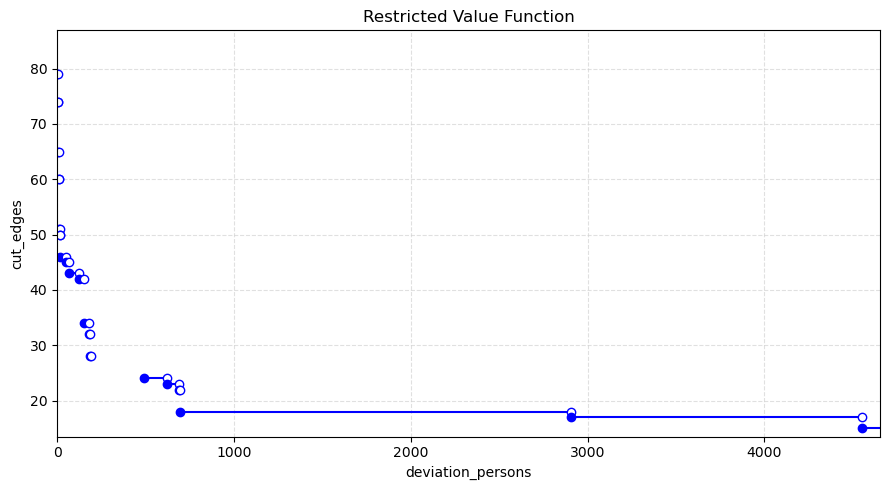

In [12]:
from pareto import ParetoFrontier

print(f"\n{'#' * 100}\nPareto Frontier for state {state},  objective {obj_type}\n{'#' * 100}\n")
pareto = ParetoFrontier(senses, obj_names, state=state, level='county')

if not  plans:
    print("No plan found!")
else:
    for plan, obj_bound, dev in result:
        upper_bound = [dev,  1/obj_bound[0] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[0]]
        lower_bound = [dev,  1/obj_bound[1] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[1]]
        
        pareto.add_plan(plan, upper_bound, lower_bound)
            
print("Pareto front plans:", pareto.plans)
print("Pareto front upper bounds:", pareto.upper_bounds)
print("Pareto front lower bounds:", pareto.lower_bounds) 

extra_points = None
extra_colors = None
        
pareto.tighten_lower_bounds()

if infeasible_region[1] > 0.5:
    max_dev = max(upper_bound[0] for upper_bound in pareto.upper_bounds)
    max_obj = max(upper_bound[1] for upper_bound in pareto.upper_bounds)
    min_obj = min(upper_bound[1] for upper_bound in pareto.upper_bounds)
    o1lim=[-1, max_dev+100]
    o2lim=[min_obj*0.9, max_obj*(1.1)]
else:
    o1lim = None
    o2lim = None

pareto.plot_with_custom_x_ranges(method = 'epsilon_constraint_method', splits=None,
                                 o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region,
                                 extra_points=extra_points, extra_colors=extra_colors)


####################################################################################################
Pareto maps for state NE, objective cut_edges
####################################################################################################



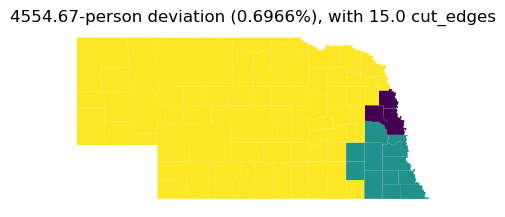

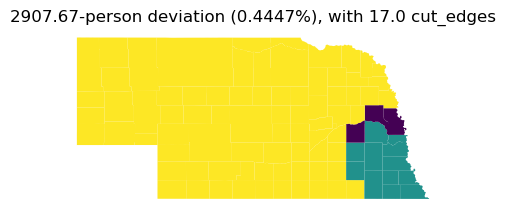

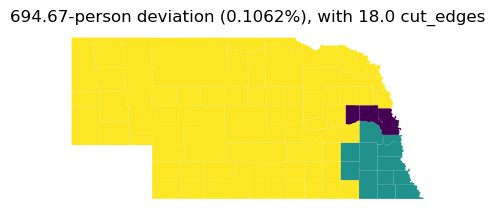

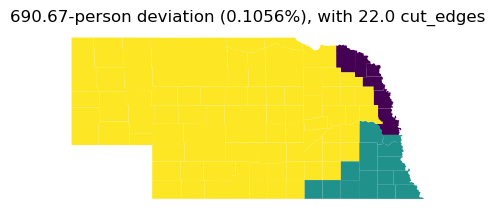

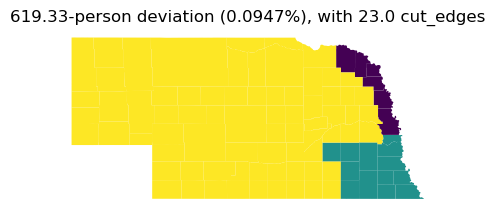

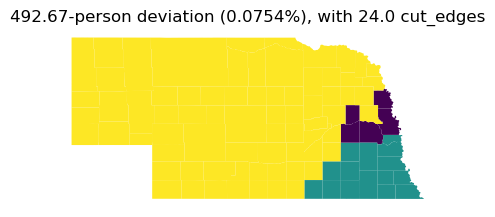

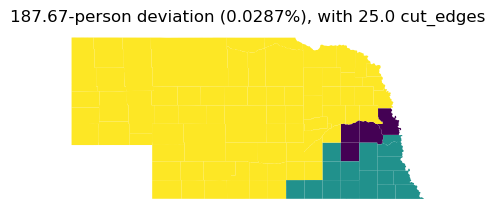

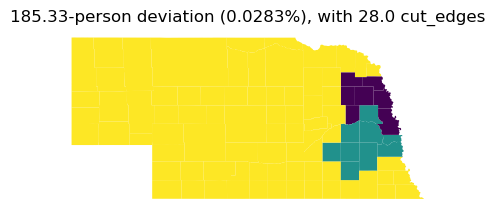

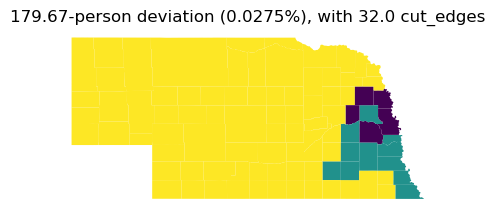

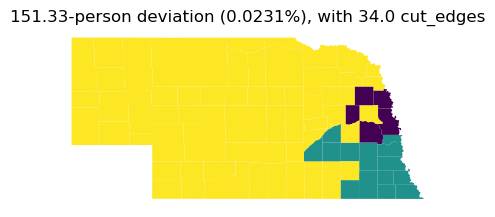

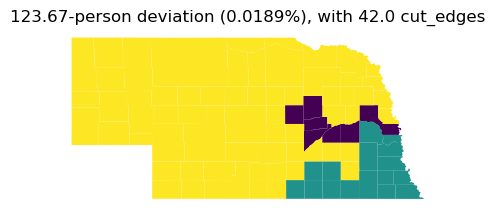

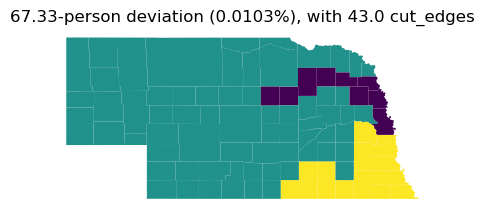

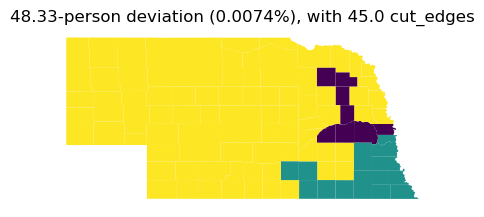

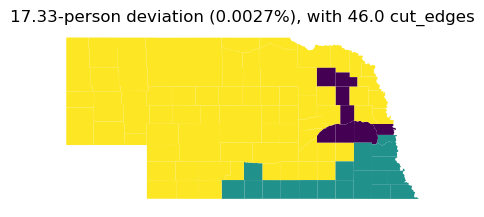

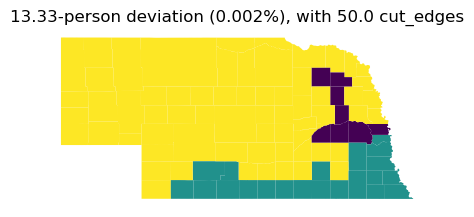

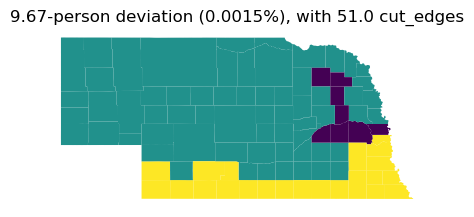

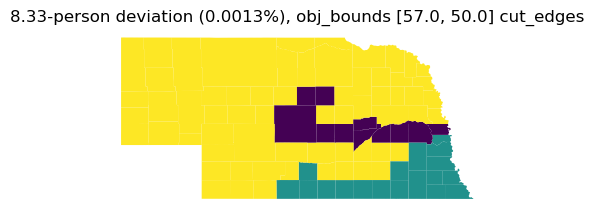

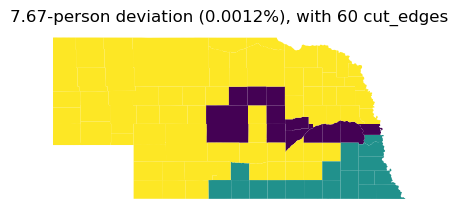

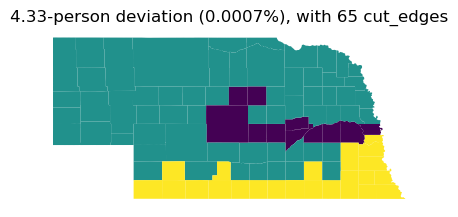

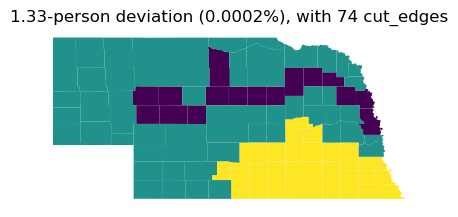

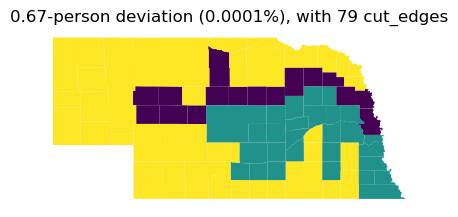

In [13]:
from draw import *

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: round(x, 0)}

for plan, obj_bound, dev in result:
    ub = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[0])
    lb = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[1])
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    if ub != lb:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), obj_bounds [{ub}, {lb}] {obj_type}"
    else:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), with {ub} {obj_type}"

    draw_plan(filepath, filename2, G, plan, title=title, year=year)